In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(device)

cuda:0


In [68]:
def show_tensor_image(image, cmap=None, label=None):
    permuted = image.permute(1, 2, 0)

    plt.imshow(permuted, cmap=cmap)

    if label is not None:
        plt.title(label)

    plt.axis('off')

    plt.show()

import math

def show_tensor_images(images, labels=None, cmap=None, save=None, filename=None, to_cpu=True):
    n_images = len(images)
    n_rows = math.ceil(math.sqrt(n_images))
    n_cols = math.ceil(n_images / n_rows)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
    axes = axes.flatten()

    for i, (image, ax) in enumerate(zip(images, axes)):
        if to_cpu:
            image = image.cpu()
        permuted = image.permute(1, 2, 0).clamp(0, 1)  # Clamp values to [0, 1]
        
        ax.imshow(permuted, cmap=cmap)
        if labels is not None:
            ax.set_title(labels[i])
        ax.axis('off')

    for i in range(n_images, len(axes)):
        axes[i].axis('off')

    if save:
        os.makedirs(save, exist_ok=True)
        save_path = os.path.join(save, filename)
        plt.savefig(save_path)

    plt.show()

# 1. Create a DataLoader

In [4]:
batch_size = 16

In [5]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, folder_path, transform=None):
        self.folder_path = folder_path
        self.image_paths = [os.path.join(folder_path, fname) for fname in os.listdir(folder_path)]
        self.transform = transform
        self.label = [1.0]
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.label) 
        return image.to(device), label.to(device)

dir_path = "crawled_cakes"

transform = transforms.Compose([
    transforms.Resize((32, 32)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=0, std=1)
])

custom_dataset = CustomDataset(dir_path, transform=transform)

data_loader = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)

torch.Size([16, 1])


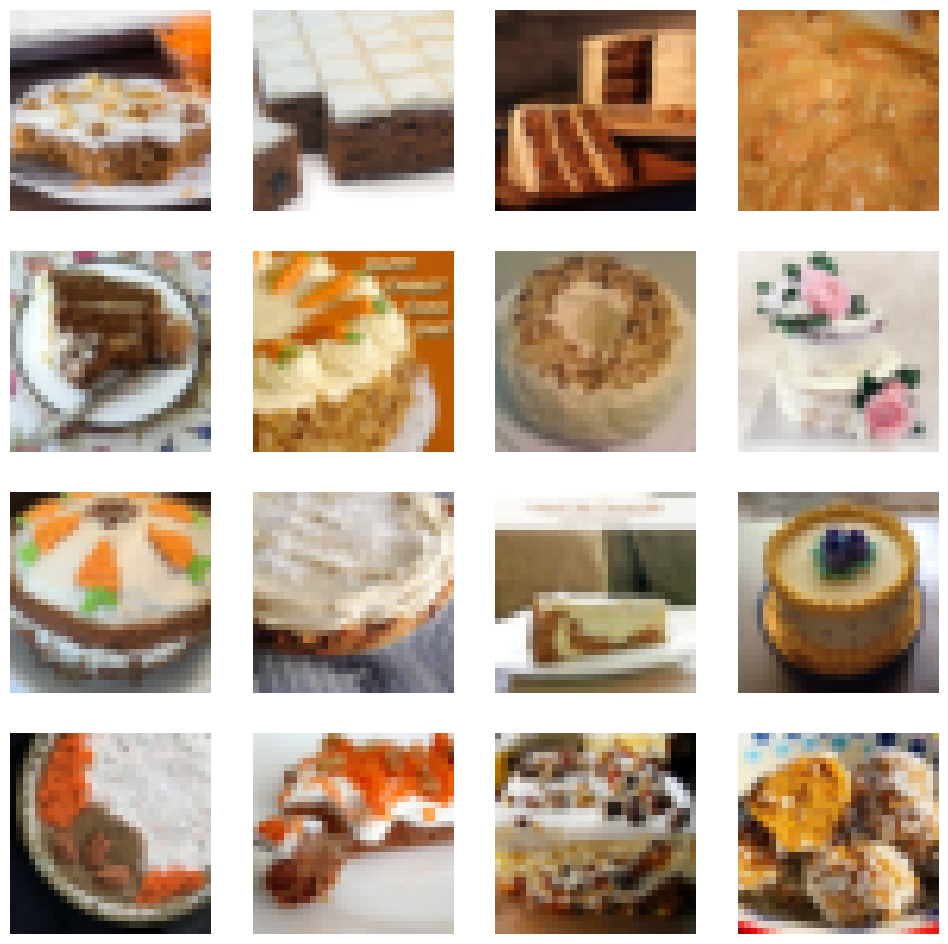

In [6]:
i = (iter(data_loader))
X_batch, y_batch = next(i)
print(y_batch.shape)

show_tensor_images(X_batch)

# 2. Create a discriminator

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.mlp = nn.Sequential(
            # input = 3 x 32 x 32
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.LeakyReLU(0.2, inplace=True),
            # current = 32 x 16 x 16
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # current = 64 x 8 x 8
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # current = 64 x 4 x 4
            nn.Flatten(),
            # current = 64*4*4
            nn.Linear(in_features=64*4*4, out_features=1),
            nn.Dropout1d(p=0.2),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.mlp(x)

# 3. Create Generator

In [9]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input = 64
            nn.Linear(in_features=64, out_features=64*4*4),
            # current = 64*4*4
            nn.Unflatten(dim=1, unflattened_size=torch.Size([64, 4, 4])),
            # current = 64 x 4 x 4
            nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # current = 64 x 8 x 8
            nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
             # current =128 x 16 x 16
            nn.ConvTranspose2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # current = 256 x 32 x 32
            nn.ConvTranspose2d(in_channels=256, out_channels=3, kernel_size=5, stride=1, padding=2, bias=False),
            nn.Tanh()
            # output = 3 x 32 x 32
        )

    def forward(self, input):
        return self.main(input)

In [10]:
test_generator = Generator()
test_generator.apply(weights_init)

Generator(
  (main): Sequential(
    (0): Linear(in_features=64, out_features=1024, bias=True)
    (1): Unflatten(dim=1, unflattened_size=torch.Size([64, 4, 4]))
    (2): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): ConvTranspose2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): ConvTranspose2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ConvTranspose2d(256, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (12): Tanh()
  )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


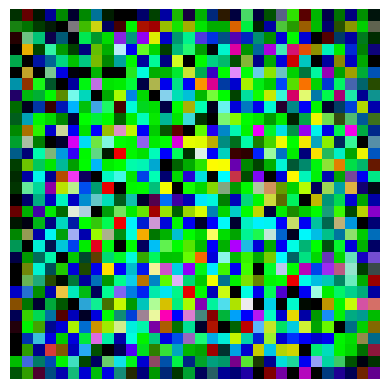

torch.Size([3, 32, 32])

In [11]:
latent_noise = torch.randn(1, 64)
random_image = test_generator(latent_noise)
show_tensor_image(random_image[0].detach())
random_image[0].detach().shape

# Test custom training loop

# Training

In [12]:
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)
generator = Generator().to(device)
generator.apply(weights_init)

Generator(
  (main): Sequential(
    (0): Linear(in_features=64, out_features=1024, bias=True)
    (1): Unflatten(dim=1, unflattened_size=torch.Size([64, 4, 4]))
    (2): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): ConvTranspose2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): ConvTranspose2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): ConvTranspose2d(256, 3, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (12): Tanh()
  )


In [13]:
criterion = nn.BCELoss()
learning_rate = 1e-5
num_epochs = 3000

verbose = 60
checkpoint = 60

fixed_noise = torch.randn(batch_size, 64).to(device)

optimizer_d = optim.Adam(discriminator.parameters(), lr=learning_rate)
optimizer_g = optim.Adam(generator.parameters(), lr=learning_rate)

In [14]:
def save_models(model_d, optim_d, model_g, optim_g, epoch, path='models'):
    torch.save({
        'epoch': epoch,
        'model_d_state_dict': model_d.state_dict(),
        'optimizer_d_state_dict': optim_d.state_dict(),
        'model_g_state_dict': model_g.state_dict(),
        'optimizer_g_state_dict': optim_g.state_dict(),
    }, f"{path}/checkpoint_epoch_{epoch}.pth")
    

## Training loop

In [15]:
from tqdm import tqdm

START


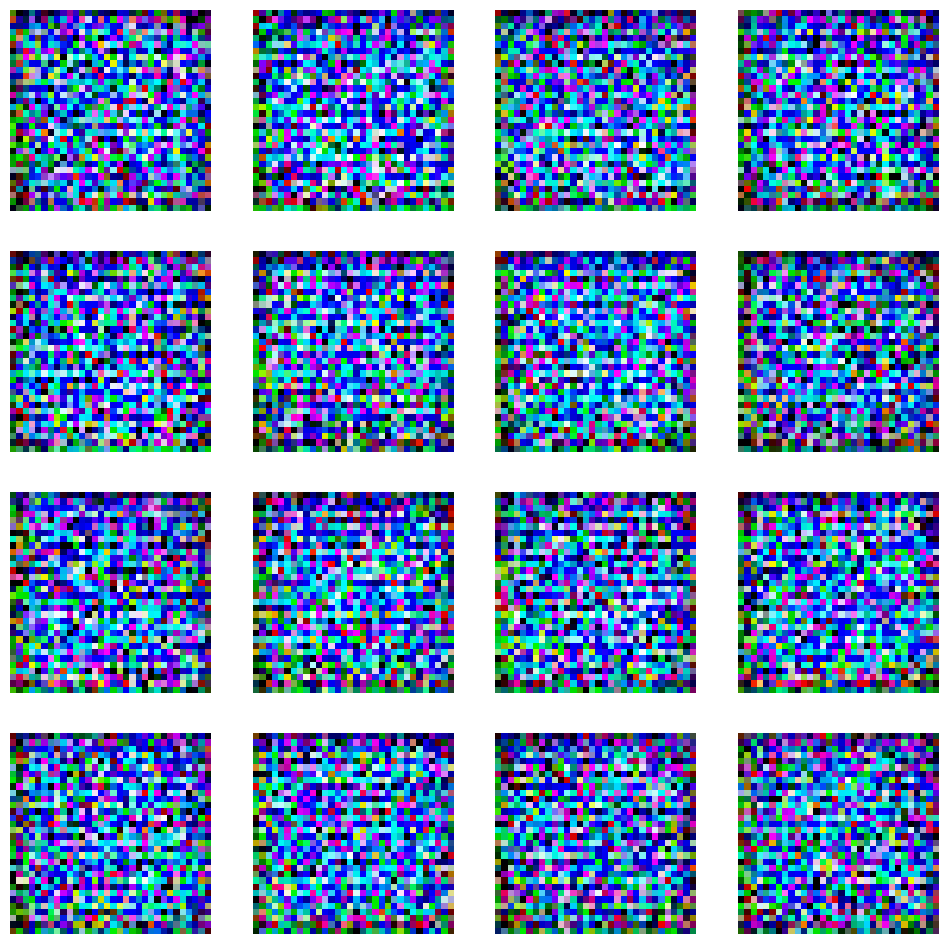

Epochs 1-60/3000: 100%|██████████| 3660/3660 [04:08<00:00, 14.73batch/s, D_loss=0.438, G_loss=3.07]


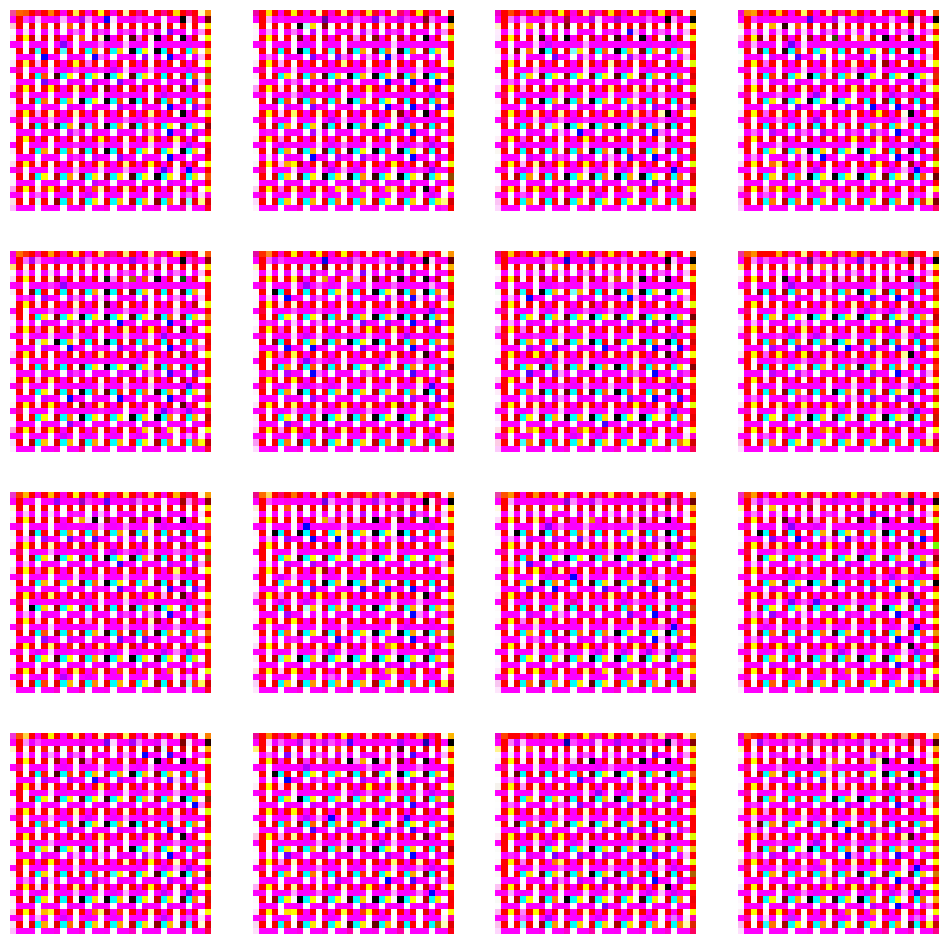

Epochs 61-120/3000: 100%|██████████| 3660/3660 [04:05<00:00, 14.91batch/s, D_loss=0.467, G_loss=2.98]


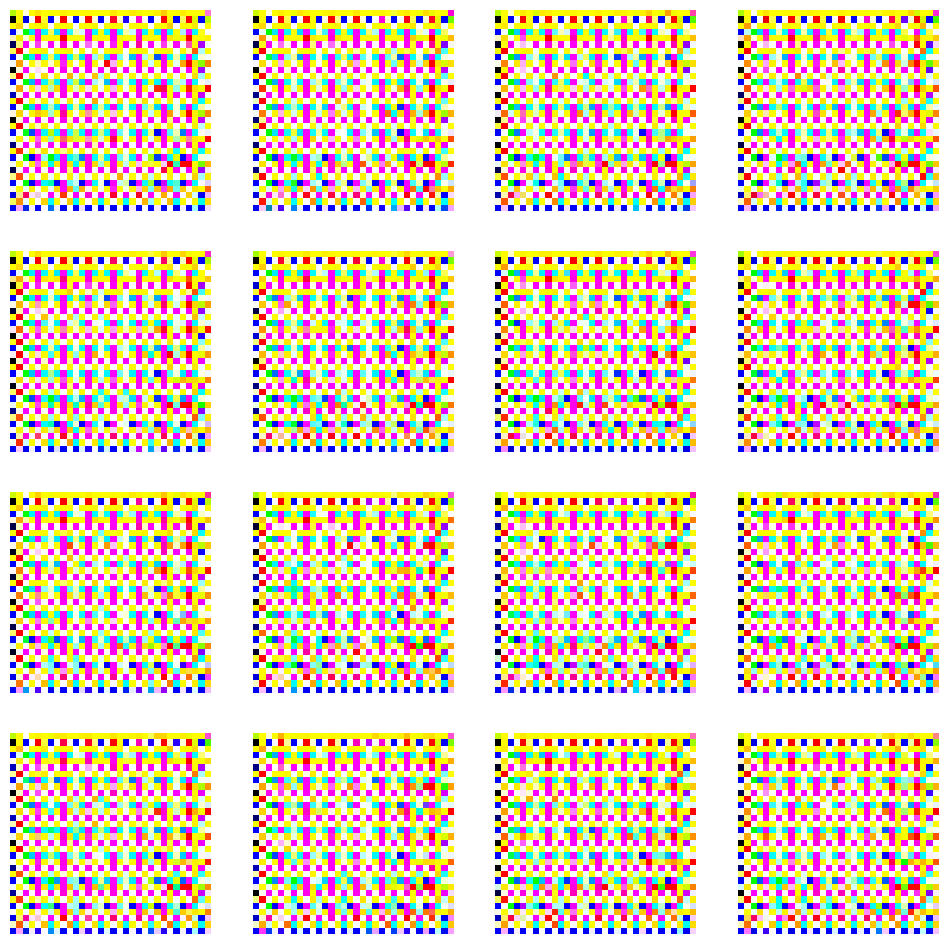

Epochs 121-180/3000: 100%|██████████| 3660/3660 [04:07<00:00, 14.79batch/s, D_loss=0.493, G_loss=3.41]


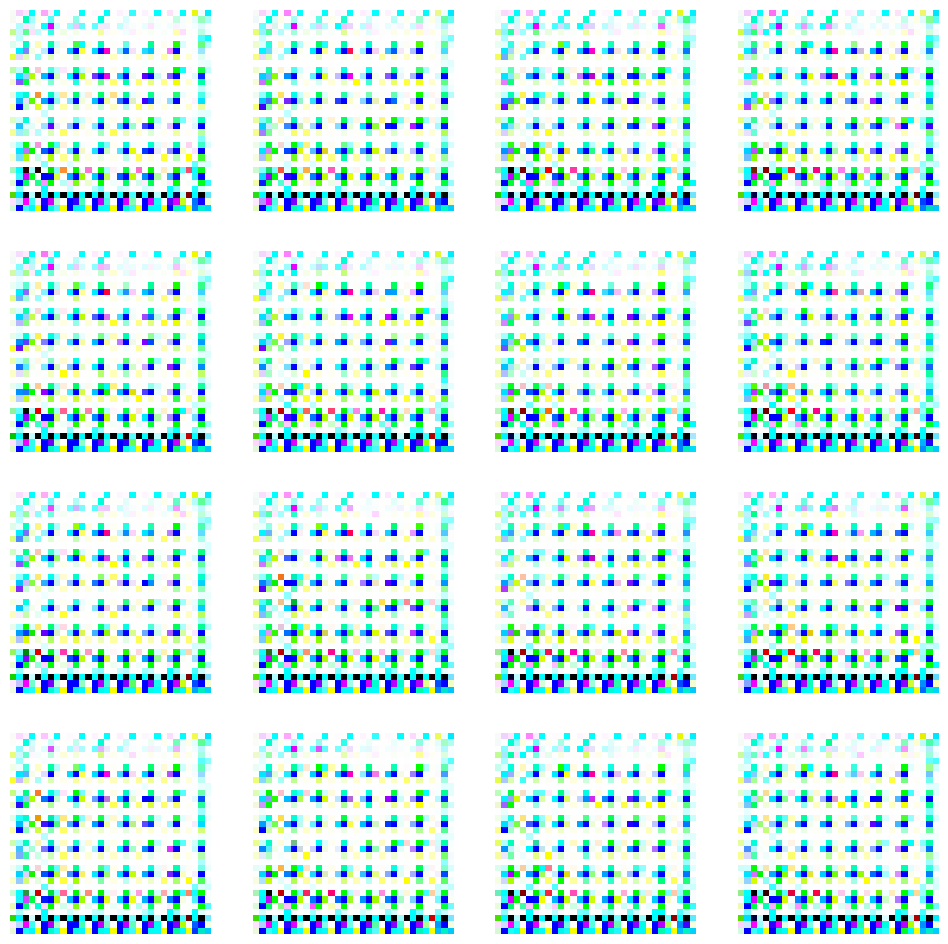

Epochs 181-240/3000: 100%|██████████| 3660/3660 [04:04<00:00, 14.94batch/s, D_loss=0.488, G_loss=3.06]


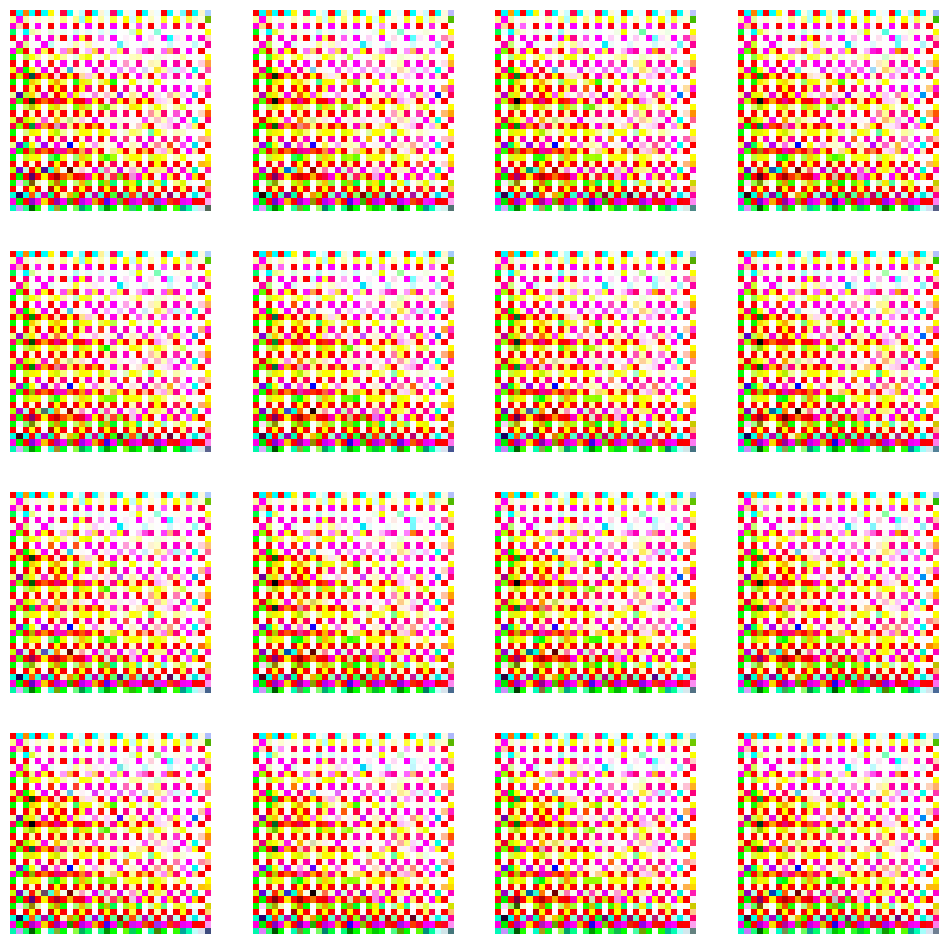

Epochs 241-300/3000: 100%|██████████| 3660/3660 [04:07<00:00, 14.78batch/s, D_loss=0.335, G_loss=2.93]


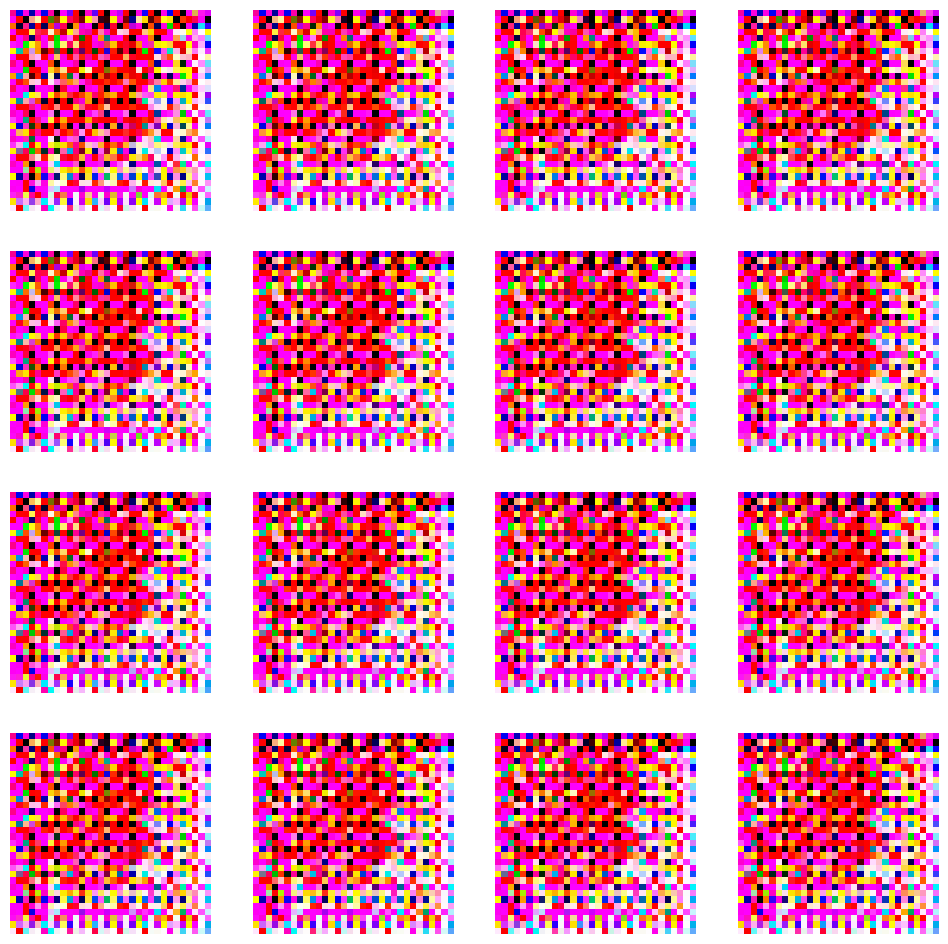

Epochs 301-360/3000: 100%|██████████| 3660/3660 [04:05<00:00, 14.92batch/s, D_loss=0.527, G_loss=3.23]


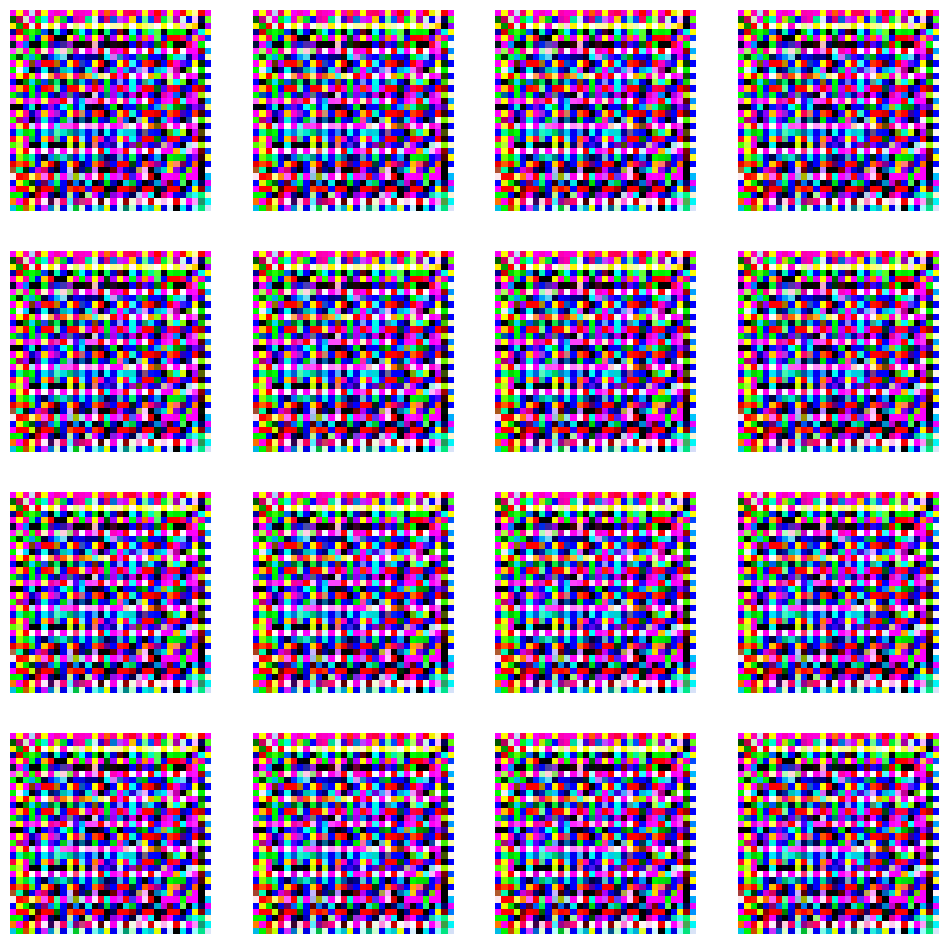

Epochs 361-420/3000: 100%|██████████| 3660/3660 [04:10<00:00, 14.64batch/s, D_loss=0.509, G_loss=2.42]


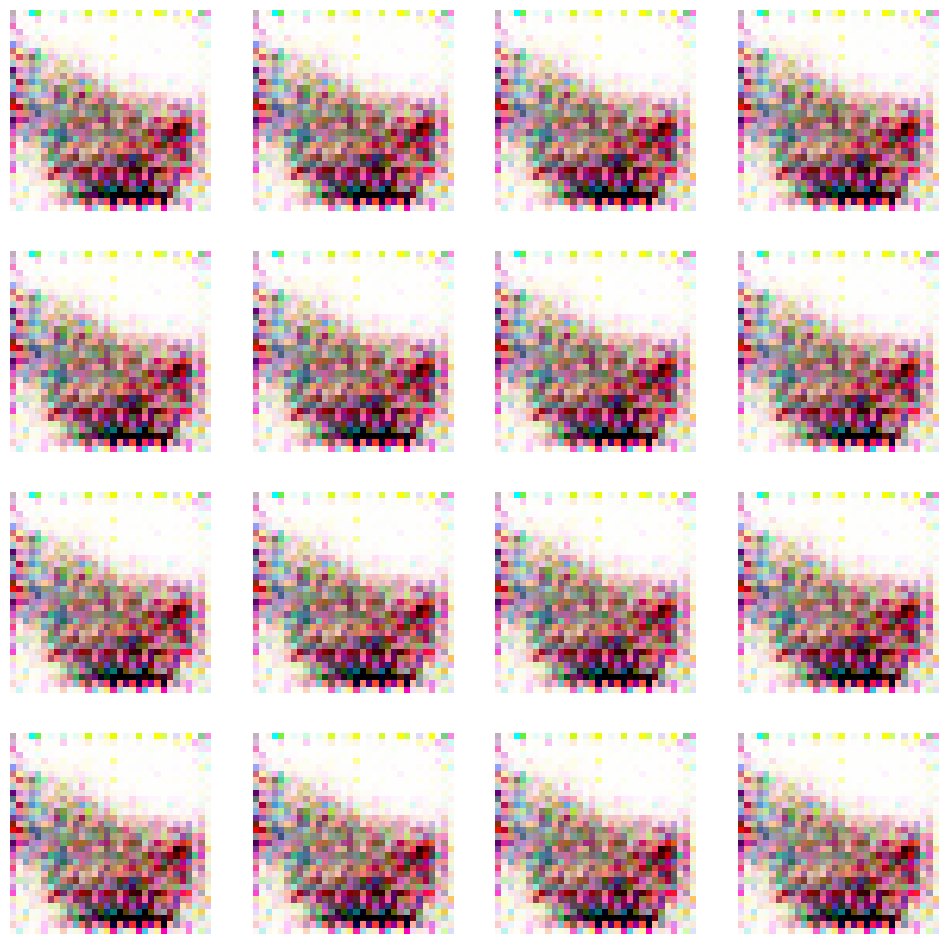

Epochs 421-480/3000: 100%|██████████| 3660/3660 [04:15<00:00, 14.35batch/s, D_loss=0.573, G_loss=1.92]


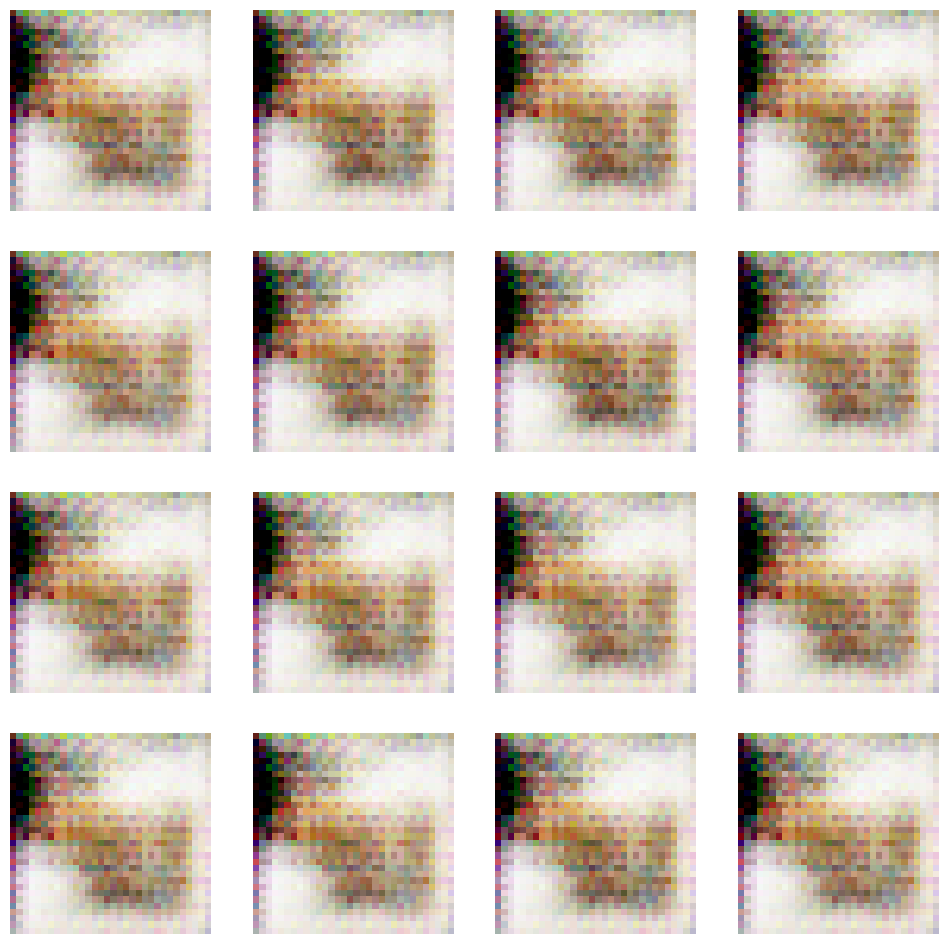

Epochs 481-540/3000: 100%|██████████| 3660/3660 [04:09<00:00, 14.67batch/s, D_loss=0.594, G_loss=1.97]


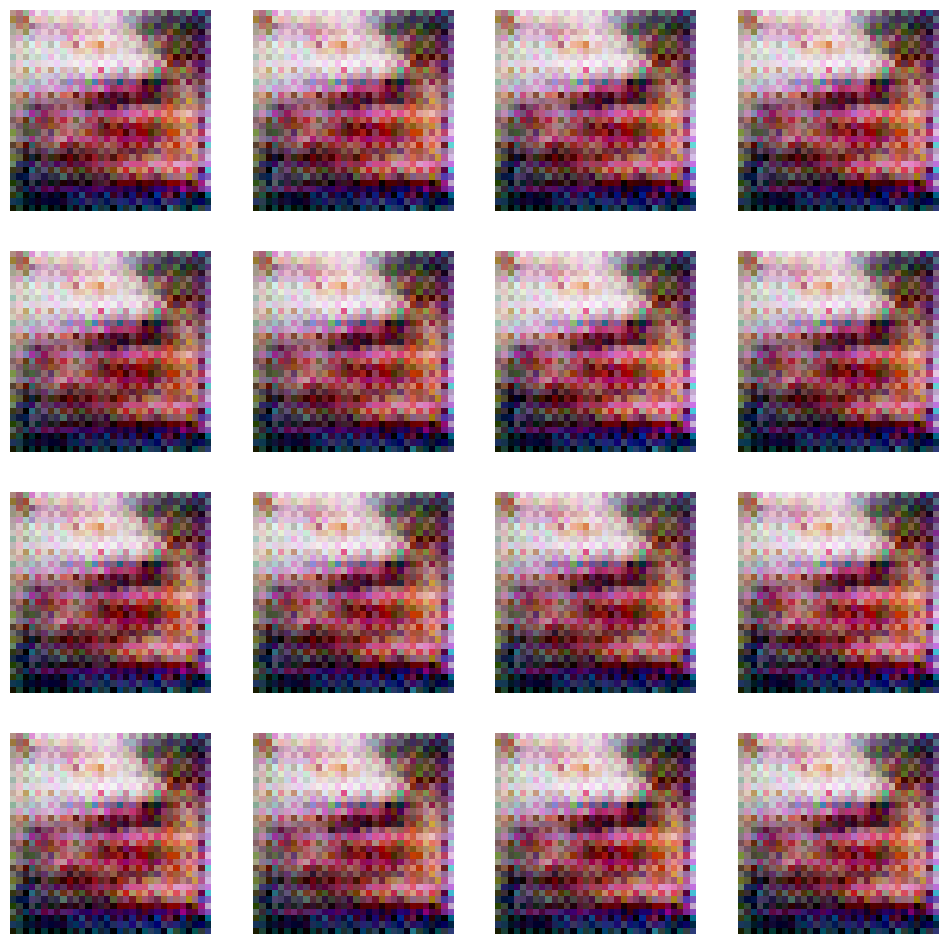

Epochs 541-600/3000: 100%|██████████| 3660/3660 [04:14<00:00, 14.38batch/s, D_loss=0.496, G_loss=2.39]


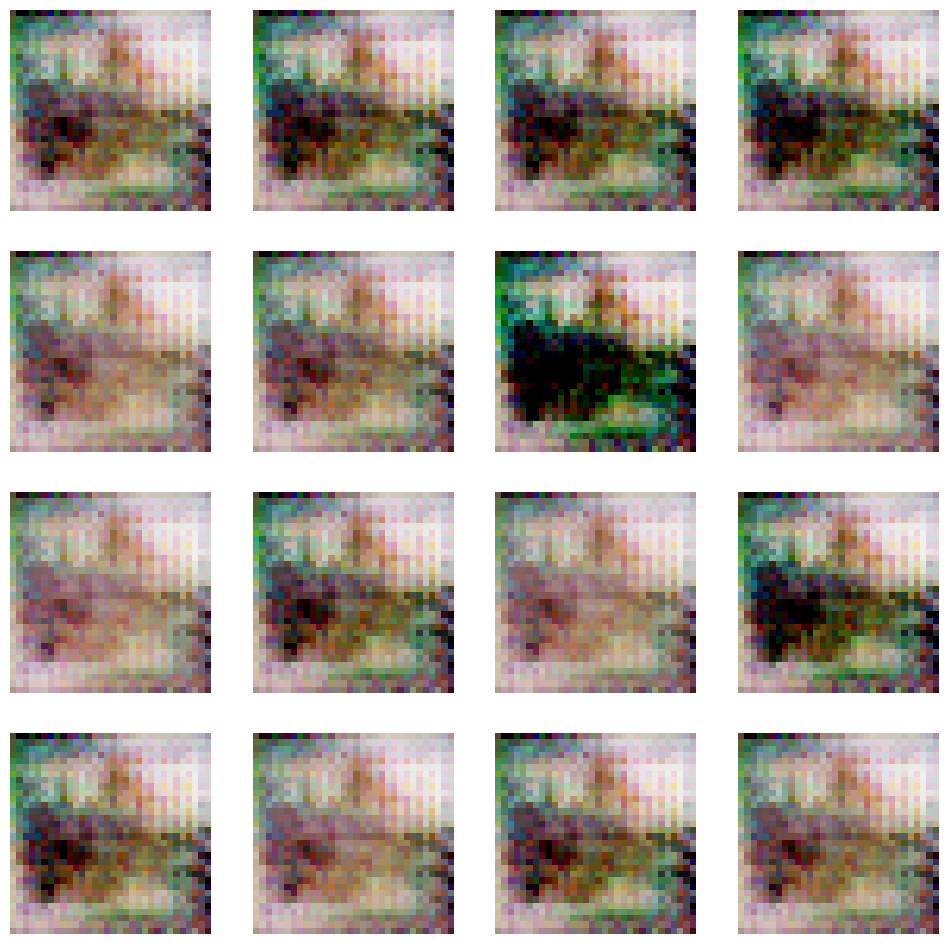

Epochs 601-660/3000: 100%|██████████| 3660/3660 [04:08<00:00, 14.71batch/s, D_loss=0.496, G_loss=1.71] 


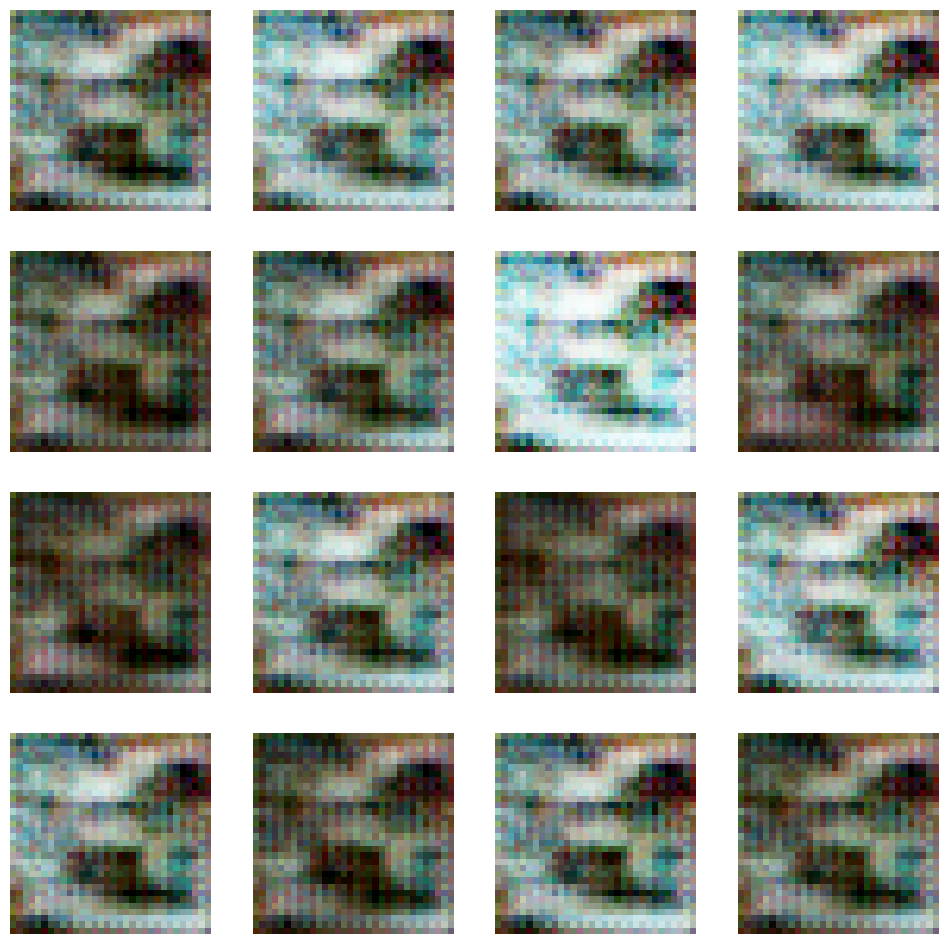

Epochs 661-720/3000: 100%|██████████| 3660/3660 [04:08<00:00, 14.74batch/s, D_loss=0.77, G_loss=1.39]  


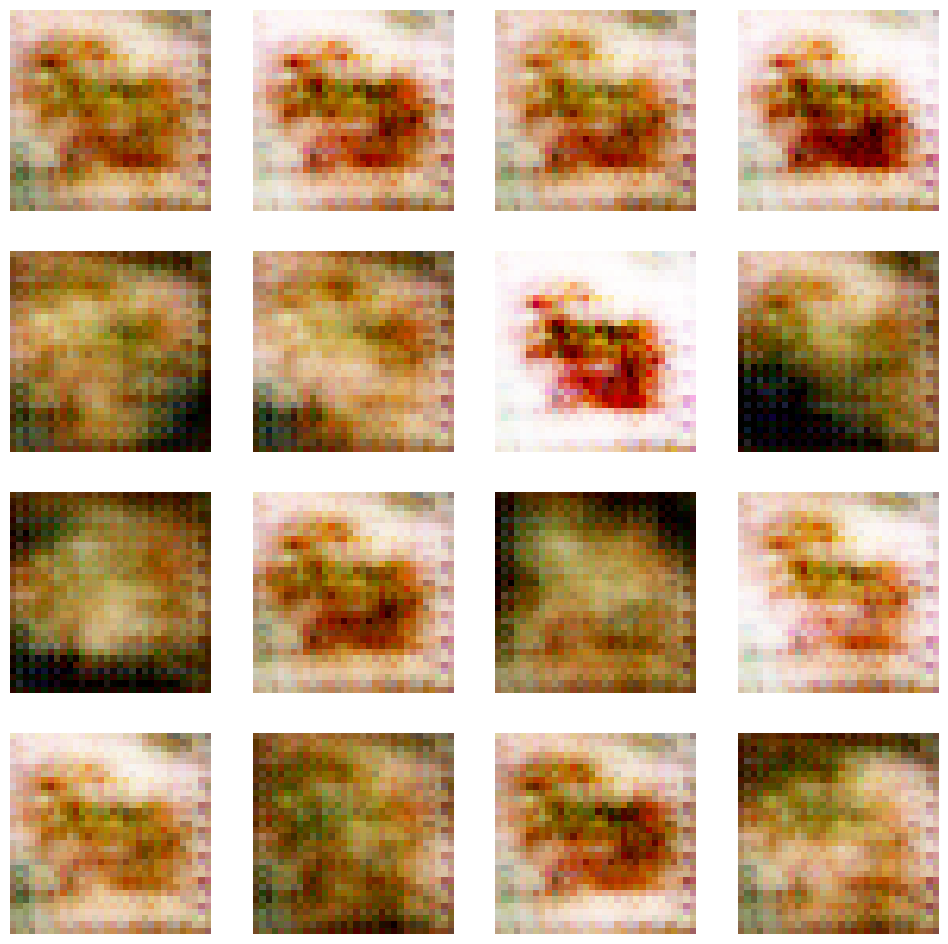

Epochs 721-780/3000: 100%|██████████| 3660/3660 [04:08<00:00, 14.71batch/s, D_loss=0.779, G_loss=1.15] 


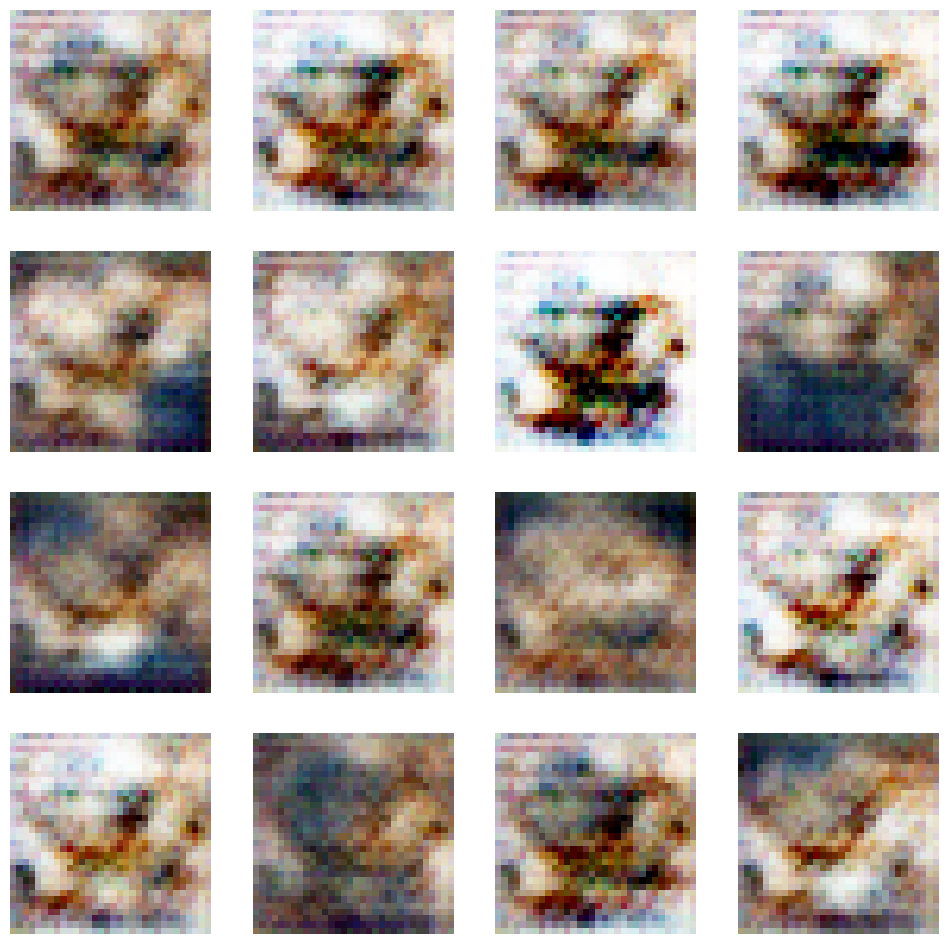

Epochs 781-840/3000: 100%|██████████| 3660/3660 [04:11<00:00, 14.58batch/s, D_loss=0.915, G_loss=1.25] 


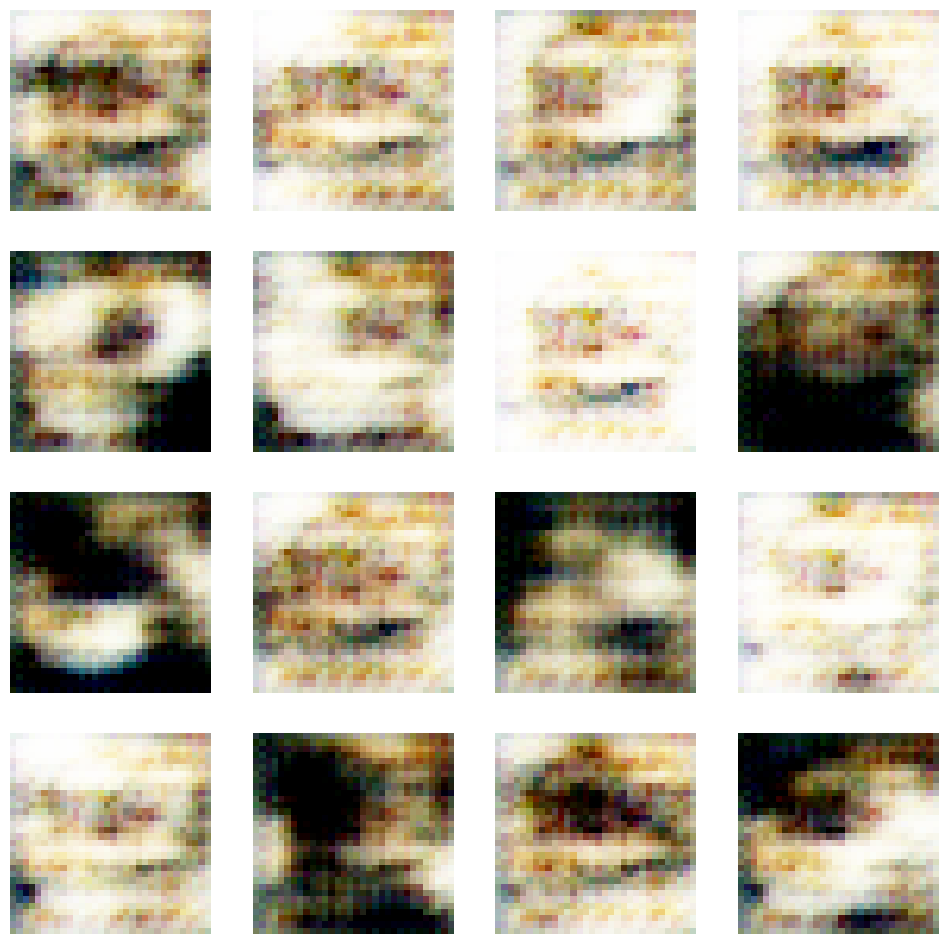

Epochs 841-900/3000: 100%|██████████| 3660/3660 [04:10<00:00, 14.60batch/s, D_loss=1, G_loss=1.56]     


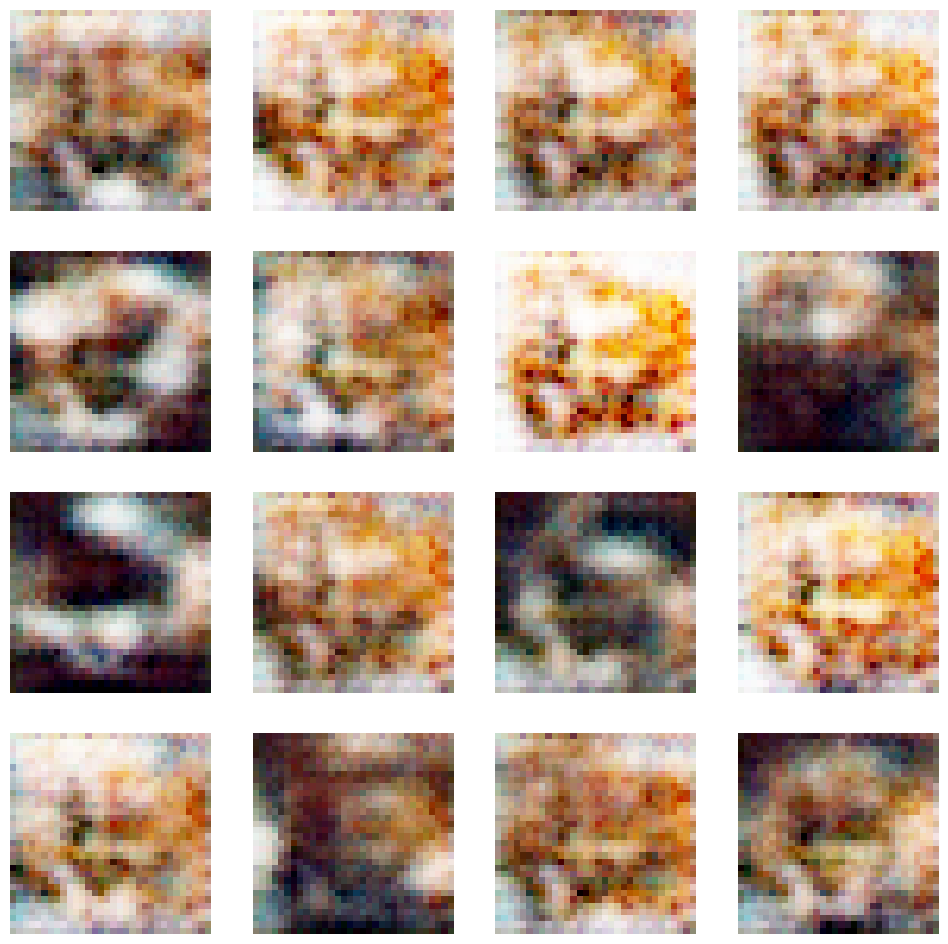

Epochs 901-960/3000: 100%|██████████| 3660/3660 [04:13<00:00, 14.46batch/s, D_loss=0.6, G_loss=2.01]   


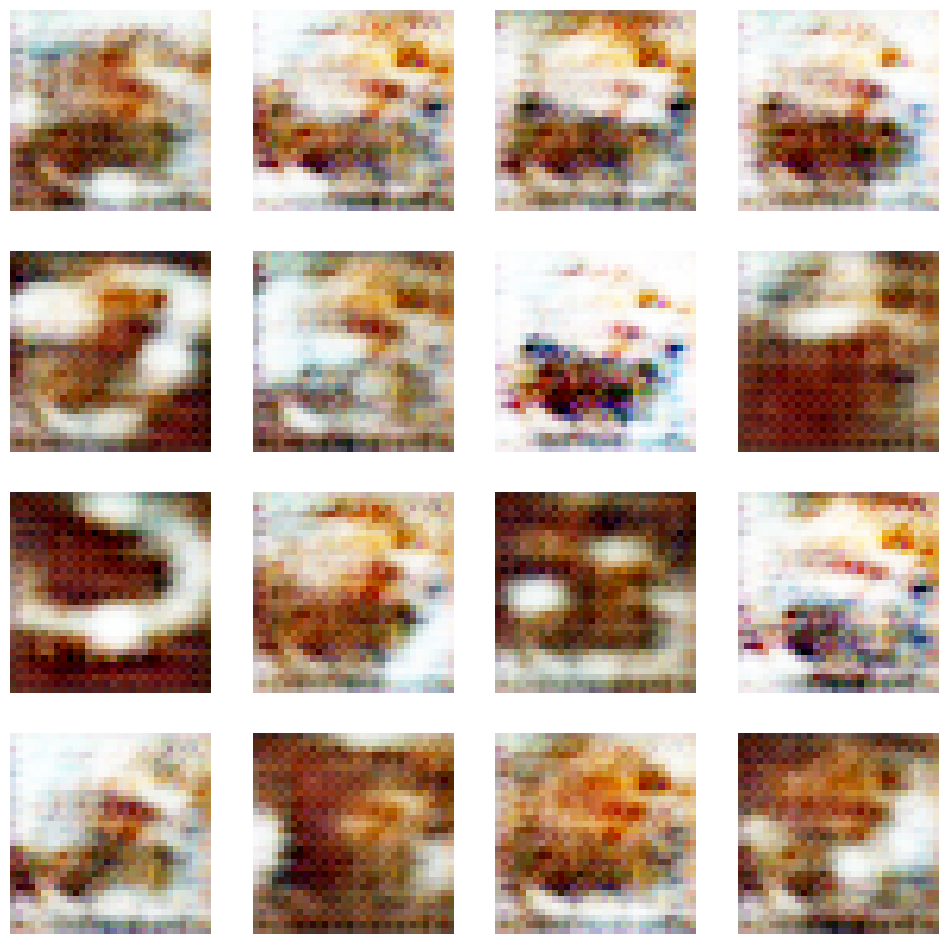

Epochs 961-1020/3000: 100%|██████████| 3660/3660 [04:11<00:00, 14.57batch/s, D_loss=0.998, G_loss=1.42] 


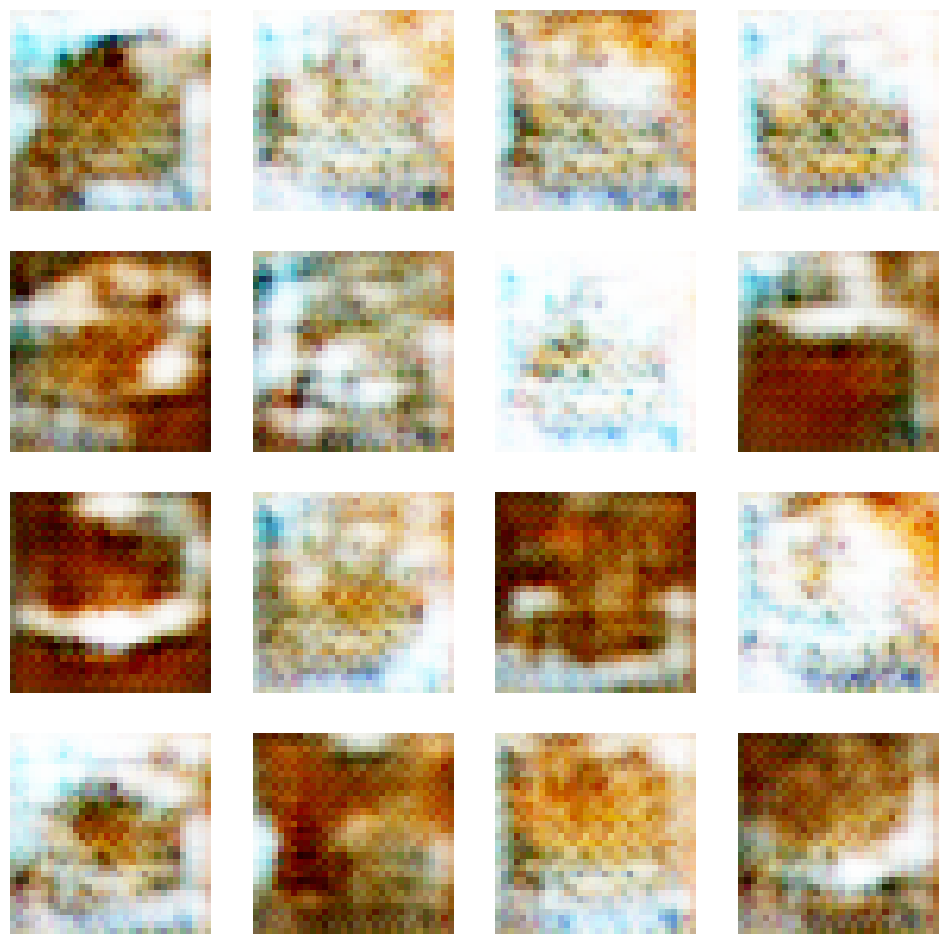

Epochs 1021-1080/3000: 100%|██████████| 3660/3660 [04:15<00:00, 14.33batch/s, D_loss=0.895, G_loss=1.16] 


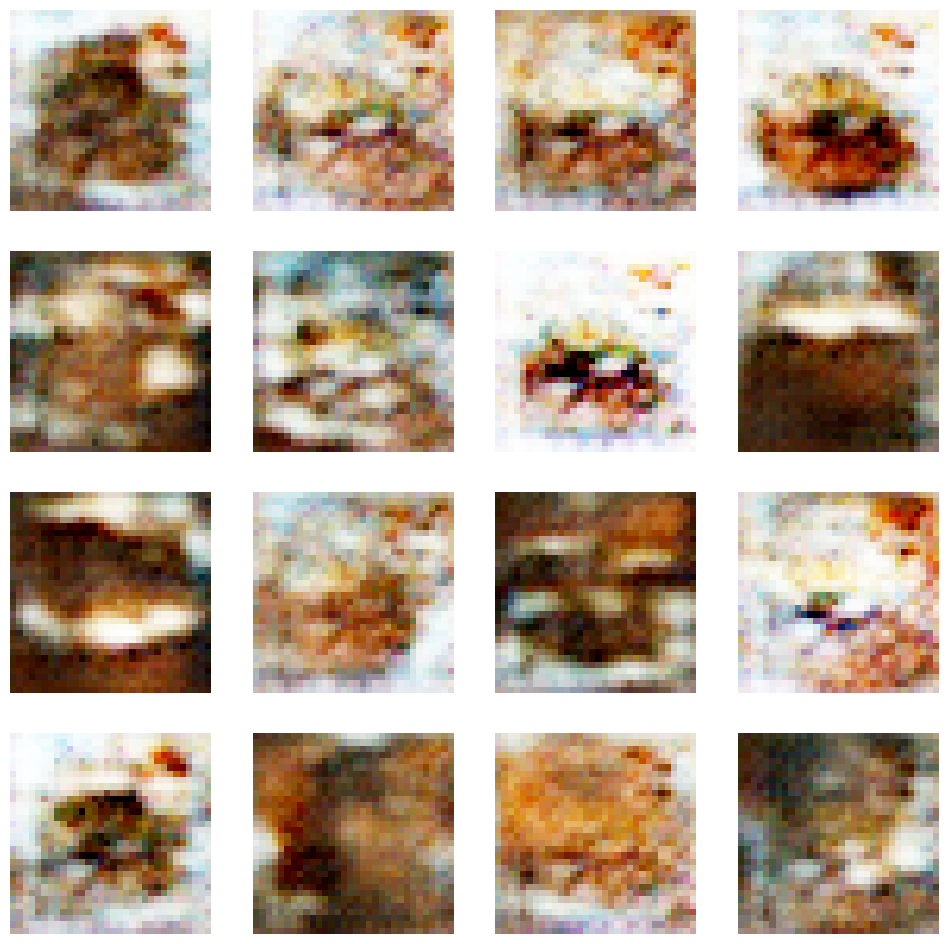

Epochs 1081-1140/3000: 100%|██████████| 3660/3660 [04:08<00:00, 14.71batch/s, D_loss=1.14, G_loss=1.32]  


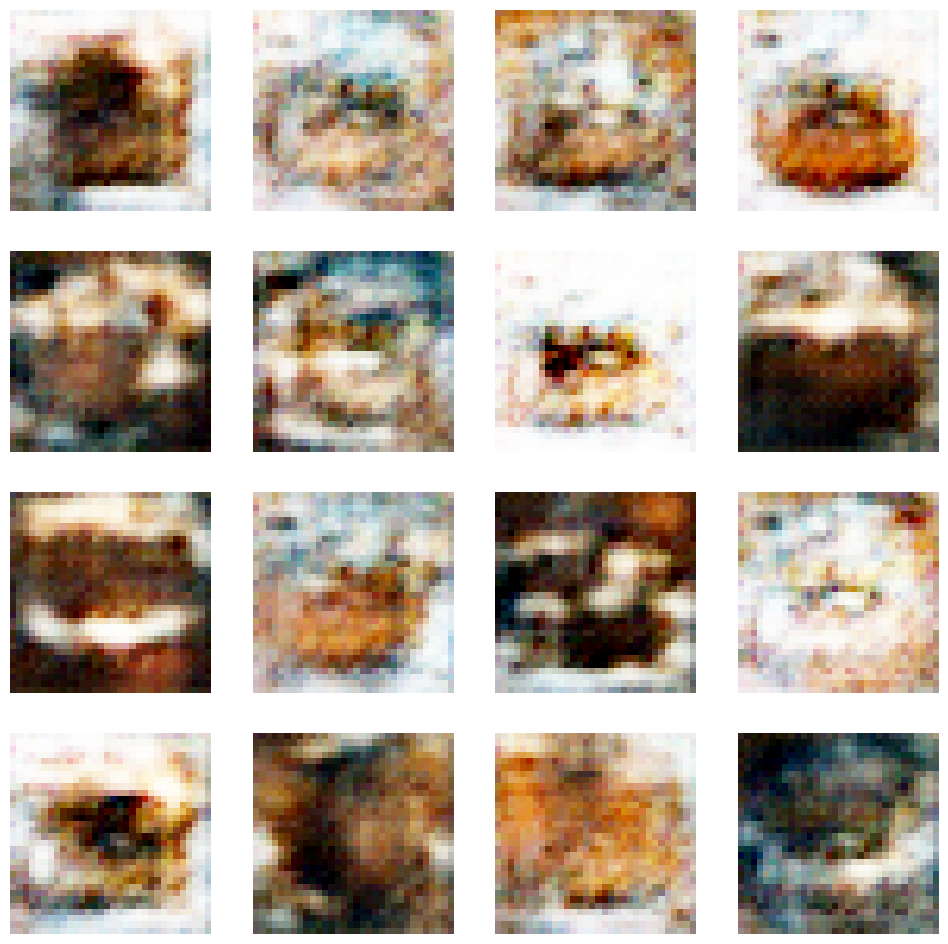

Epochs 1141-1200/3000: 100%|██████████| 3660/3660 [04:09<00:00, 14.66batch/s, D_loss=1.1, G_loss=1.29]   


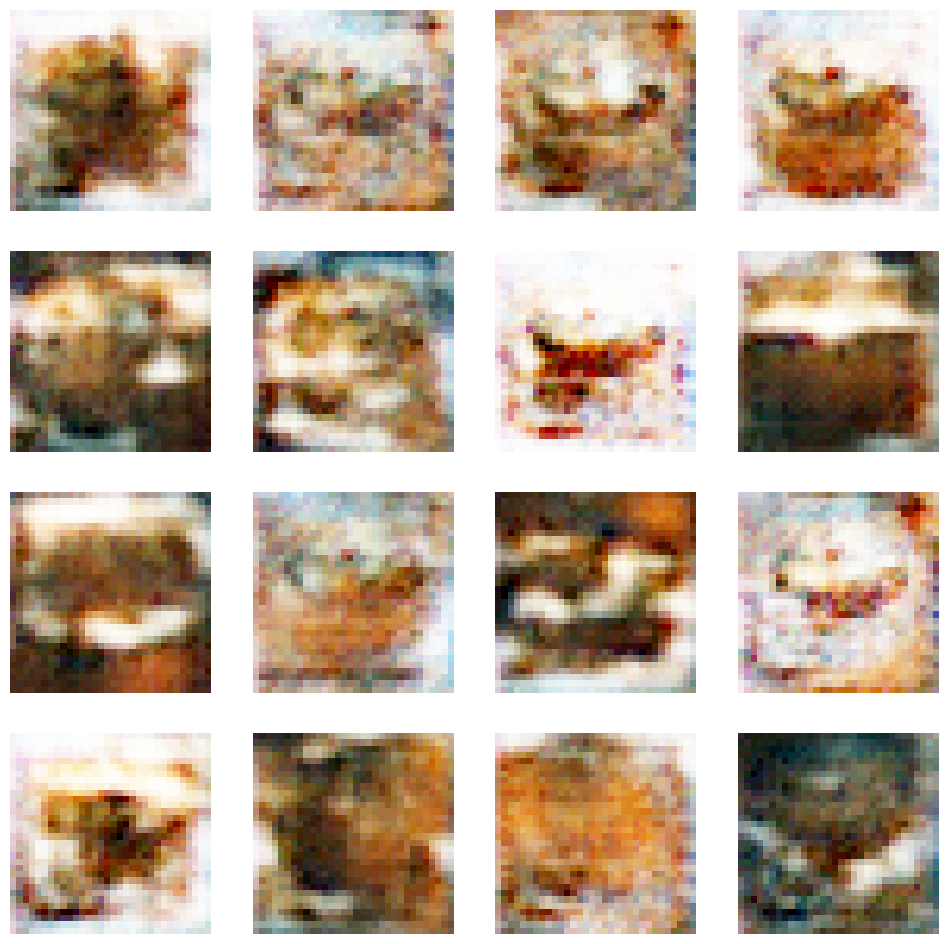

Epochs 1201-1260/3000: 100%|██████████| 3660/3660 [04:06<00:00, 14.84batch/s, D_loss=0.892, G_loss=1.23] 


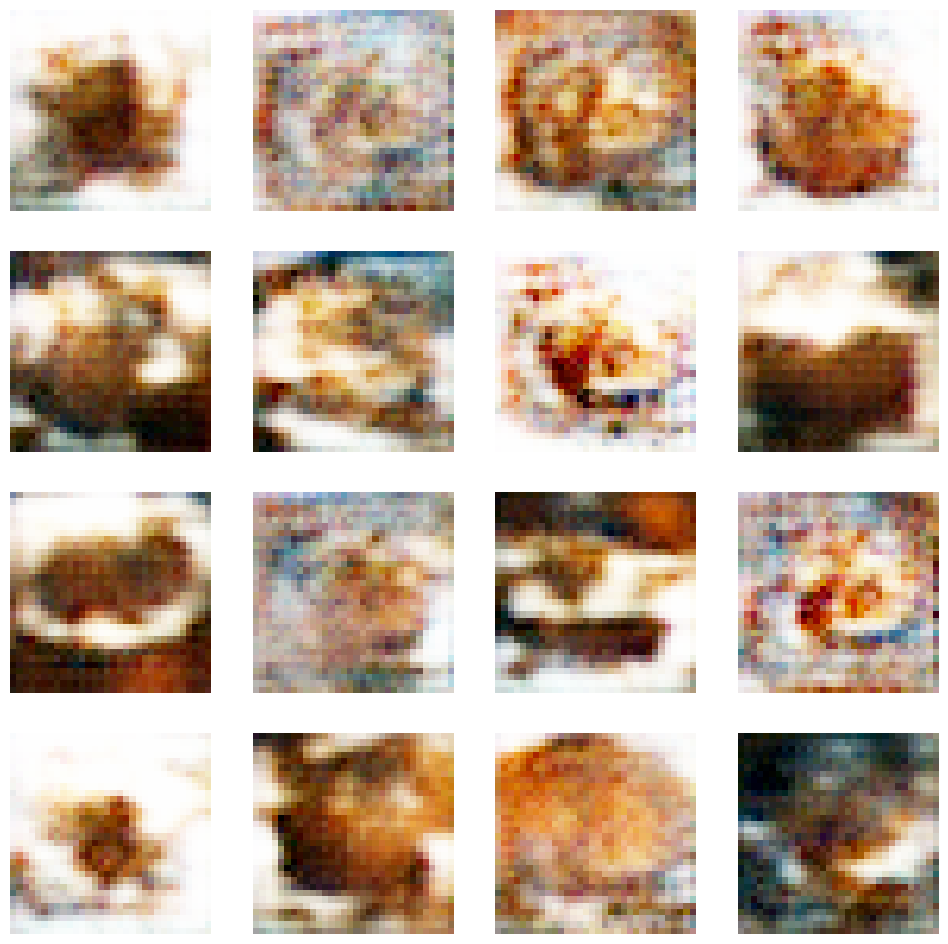

Epochs 1261-1320/3000: 100%|██████████| 3660/3660 [04:08<00:00, 14.73batch/s, D_loss=0.766, G_loss=1.66] 


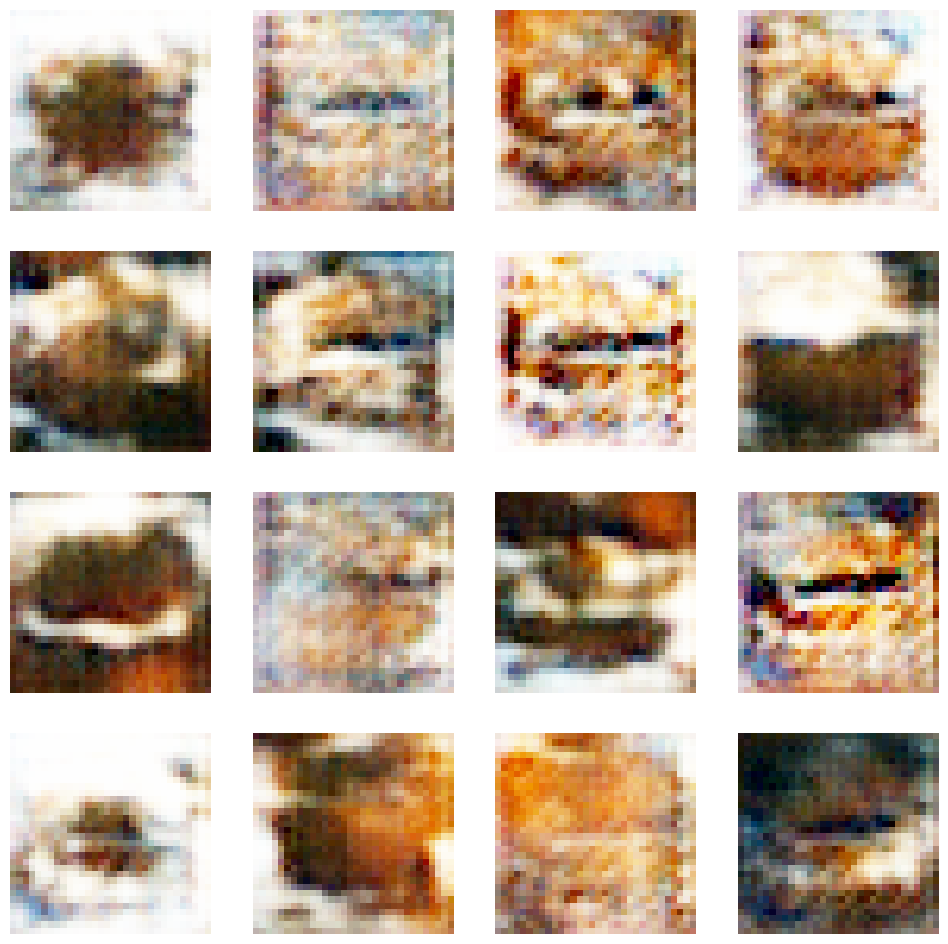

Epochs 1321-1380/3000: 100%|██████████| 3660/3660 [04:07<00:00, 14.81batch/s, D_loss=0.66, G_loss=1.4]   


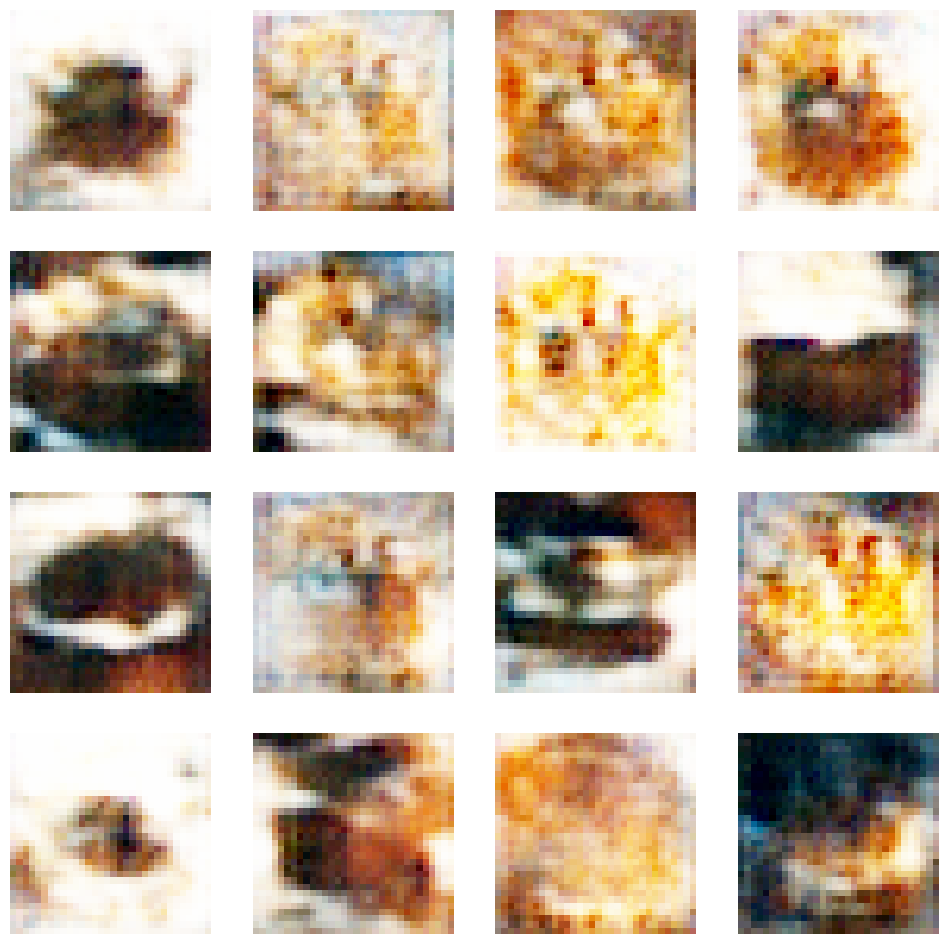

Epochs 1381-1440/3000: 100%|██████████| 3660/3660 [04:09<00:00, 14.68batch/s, D_loss=0.875, G_loss=2.1]  


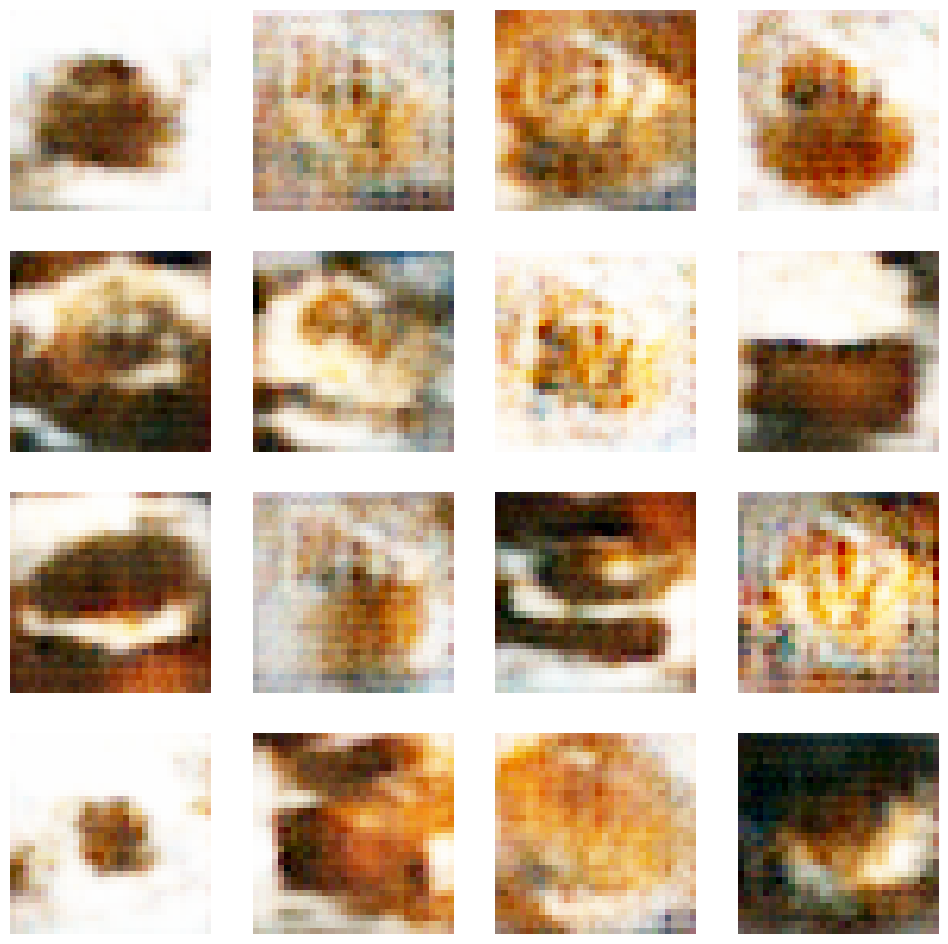

Epochs 1441-1500/3000: 100%|██████████| 3660/3660 [04:07<00:00, 14.79batch/s, D_loss=0.84, G_loss=1.85]  


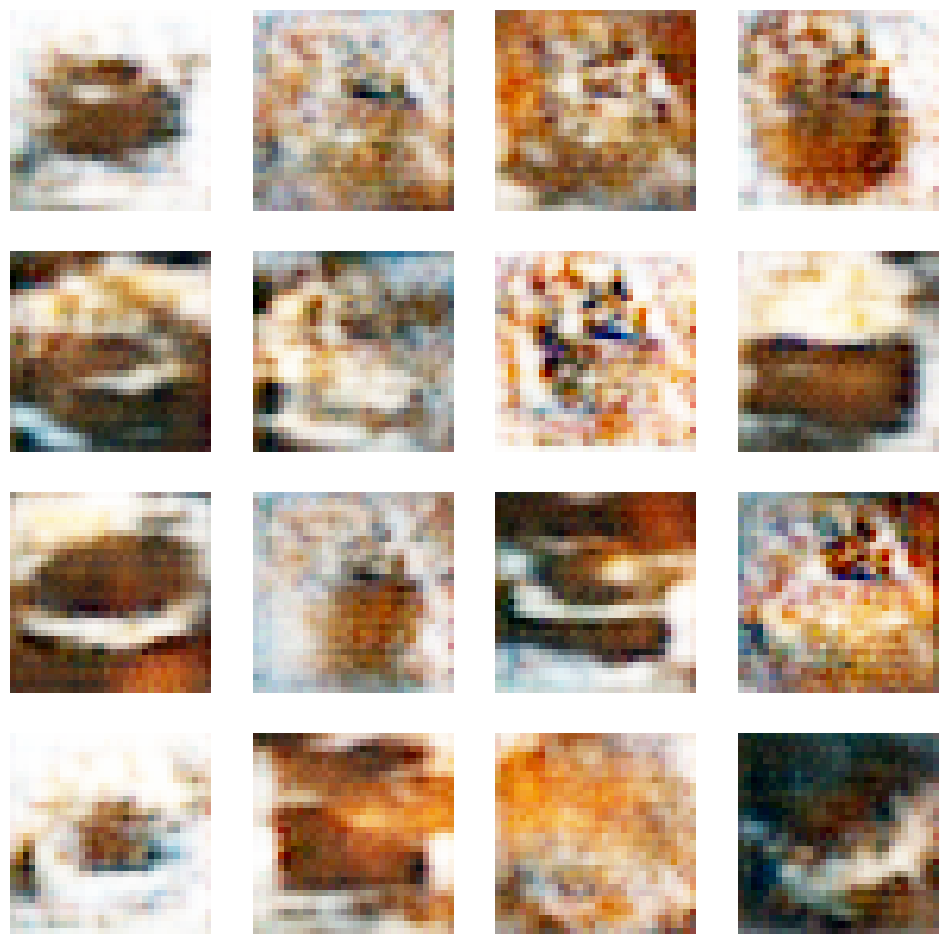

Epochs 1501-1560/3000: 100%|██████████| 3660/3660 [04:09<00:00, 14.69batch/s, D_loss=0.884, G_loss=1.35] 


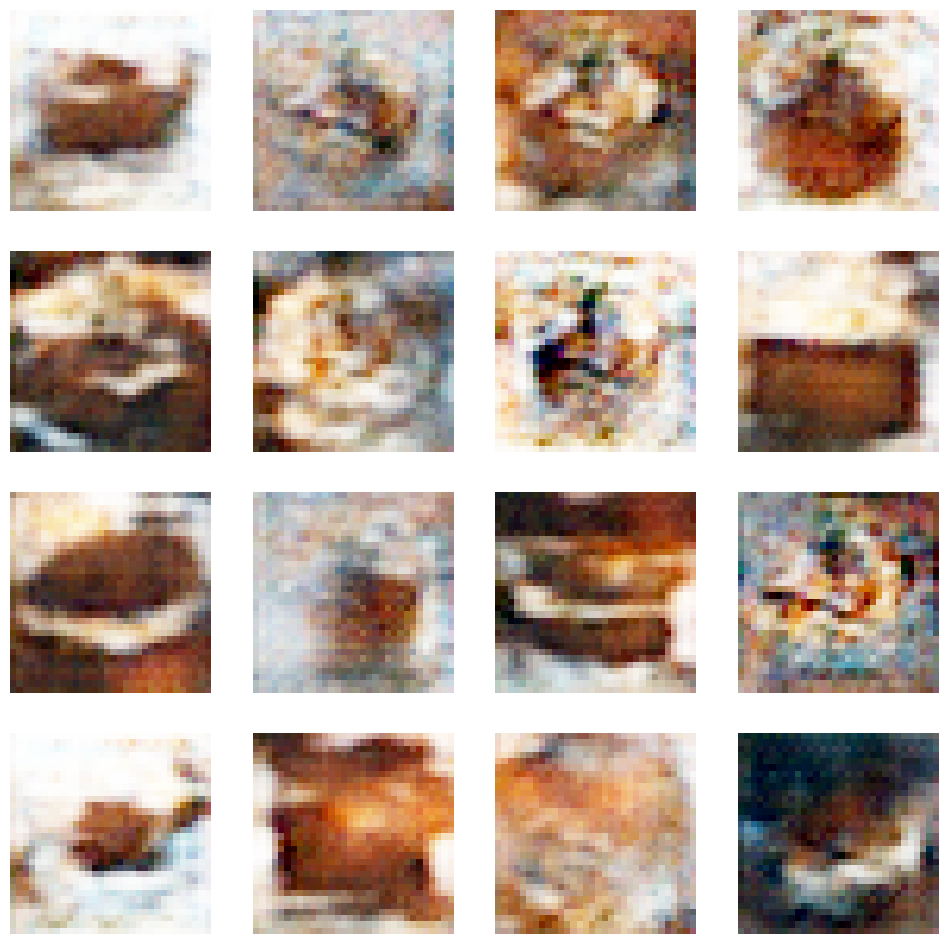

Epochs 1561-1620/3000: 100%|██████████| 3660/3660 [04:07<00:00, 14.81batch/s, D_loss=1.04, G_loss=1.58]  


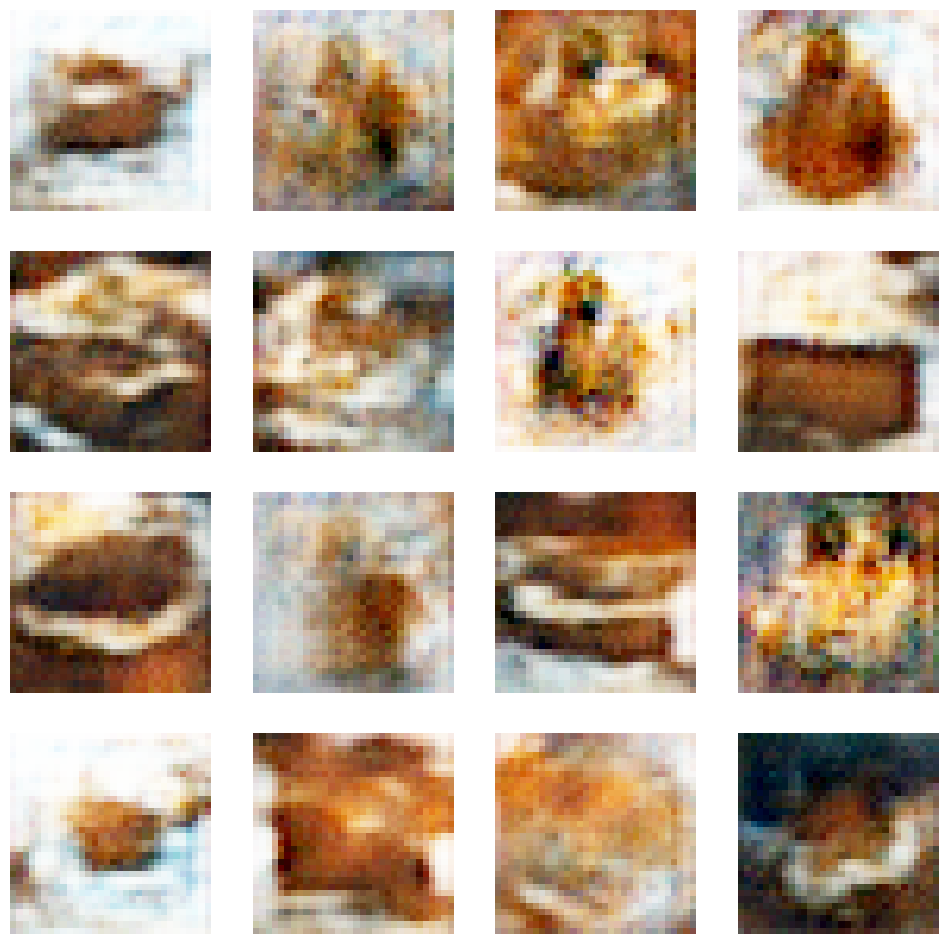

Epochs 1621-1680/3000: 100%|██████████| 3660/3660 [04:09<00:00, 14.68batch/s, D_loss=0.719, G_loss=2.22] 


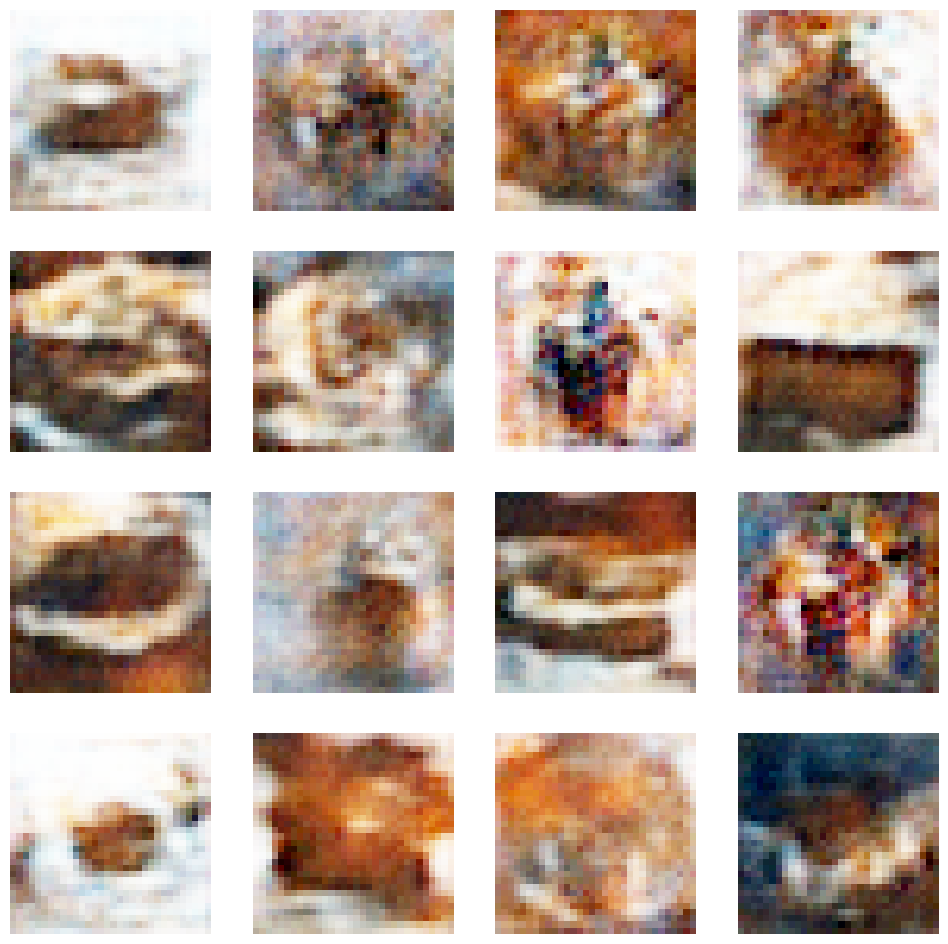

Epochs 1681-1740/3000: 100%|██████████| 3660/3660 [04:06<00:00, 14.87batch/s, D_loss=0.617, G_loss=1.91] 


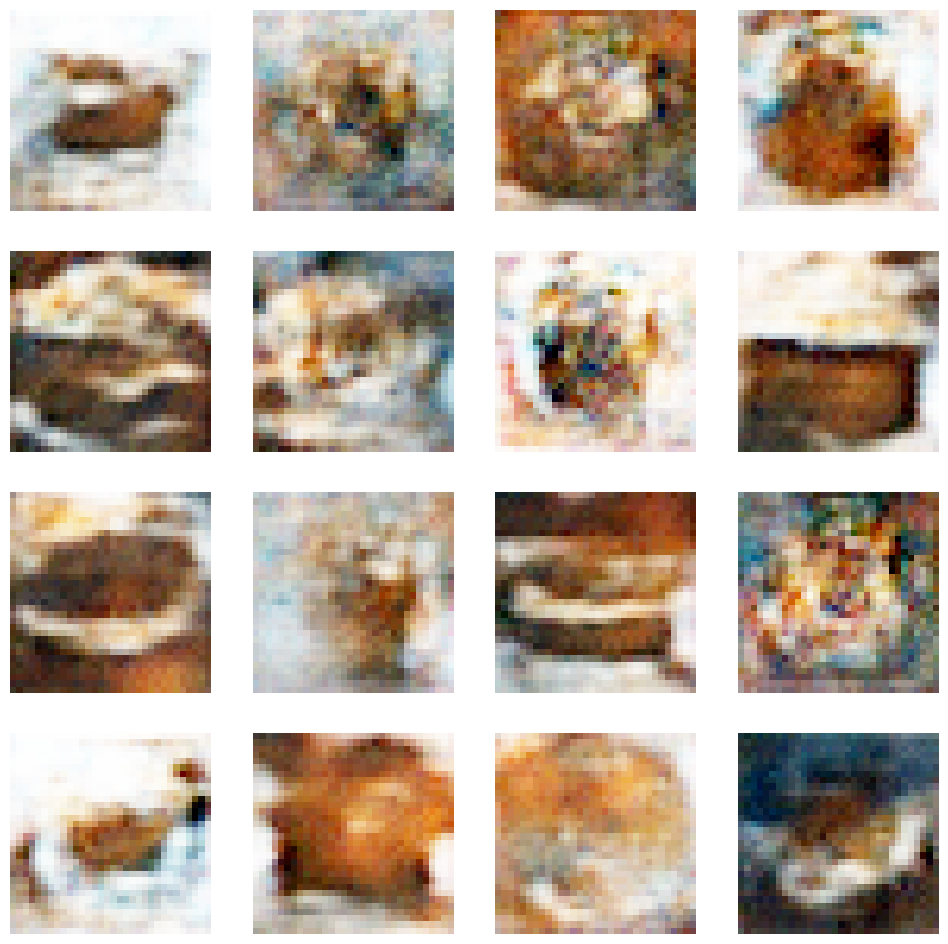

Epochs 1741-1800/3000: 100%|██████████| 3660/3660 [04:09<00:00, 14.65batch/s, D_loss=0.607, G_loss=2.08] 


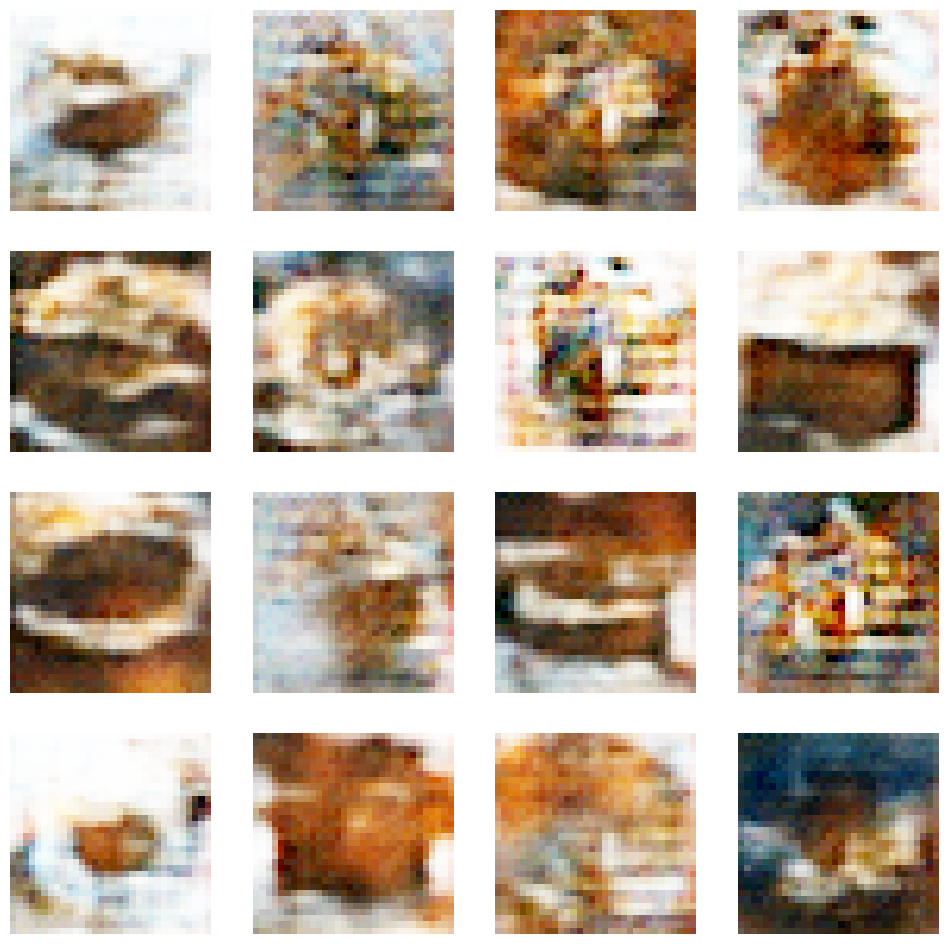

Epochs 1801-1860/3000: 100%|██████████| 3660/3660 [04:07<00:00, 14.79batch/s, D_loss=0.779, G_loss=2.01] 


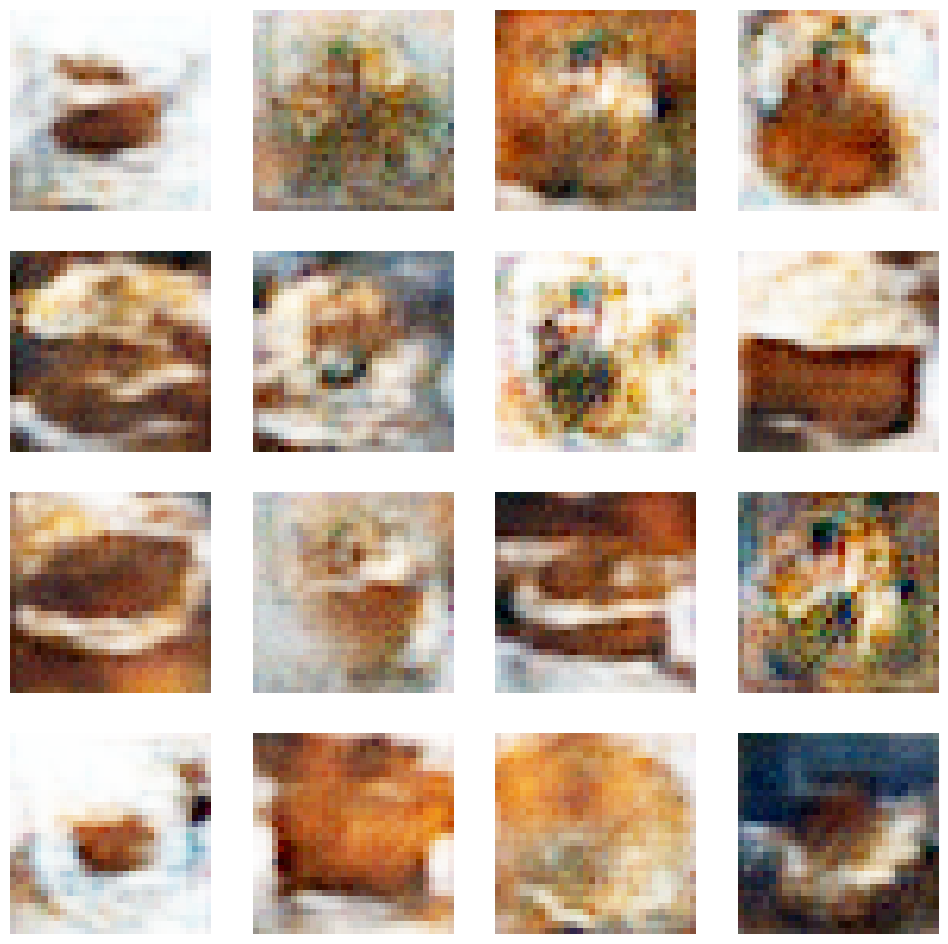

Epochs 1861-1920/3000: 100%|██████████| 3660/3660 [04:29<00:00, 13.56batch/s, D_loss=0.564, G_loss=1.44] 


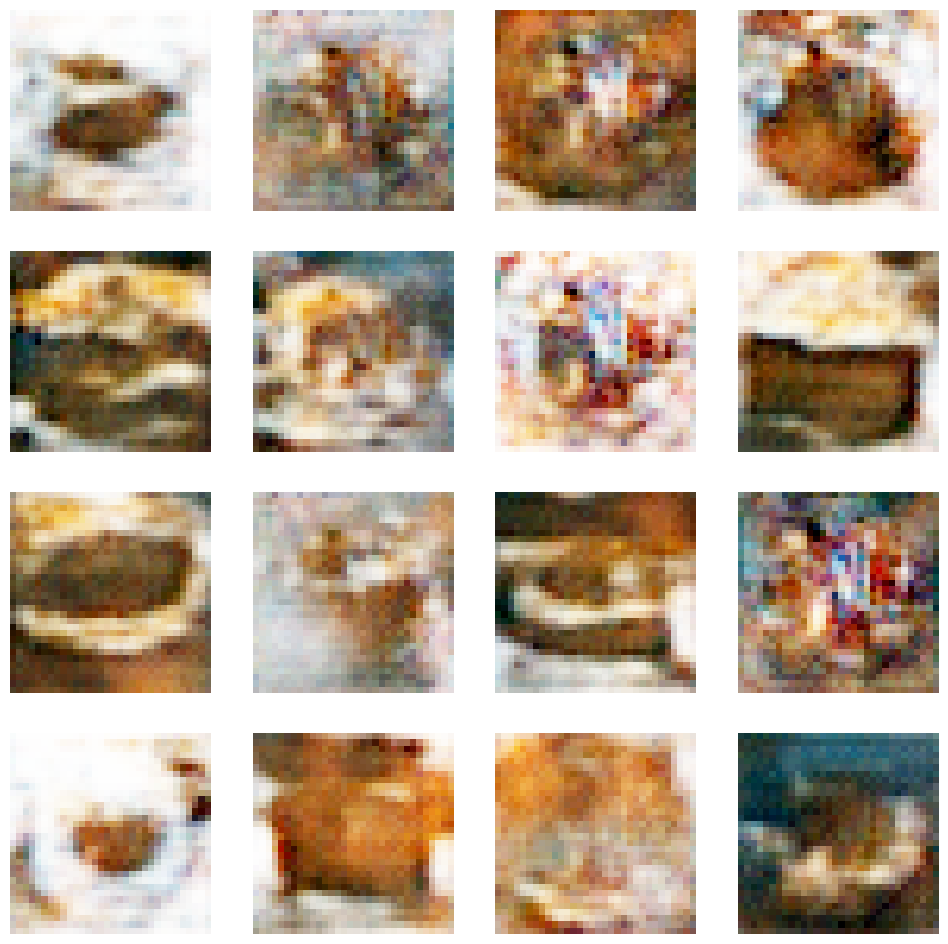

Epochs 1921-1980/3000: 100%|██████████| 3660/3660 [04:15<00:00, 14.30batch/s, D_loss=0.565, G_loss=2.5]  


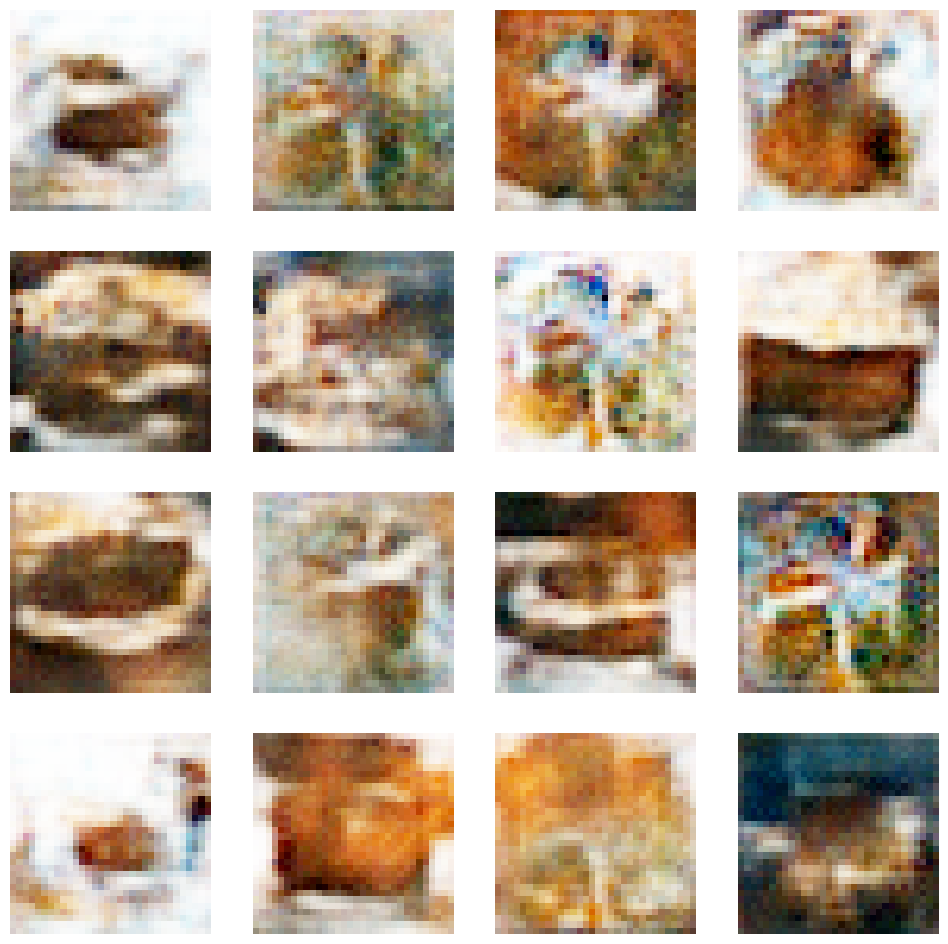

Epochs 1981-2040/3000: 100%|██████████| 3660/3660 [04:11<00:00, 14.53batch/s, D_loss=0.687, G_loss=2.39] 


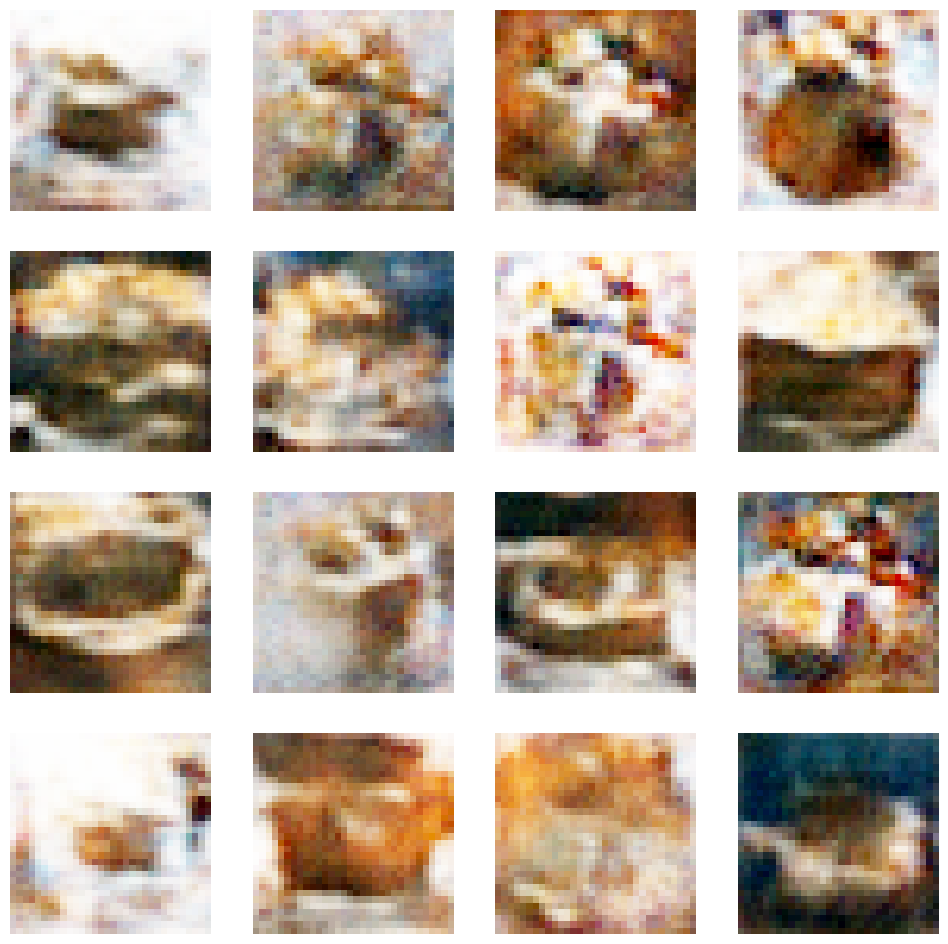

Epochs 2041-2100/3000: 100%|██████████| 3660/3660 [04:14<00:00, 14.36batch/s, D_loss=0.628, G_loss=2.71]


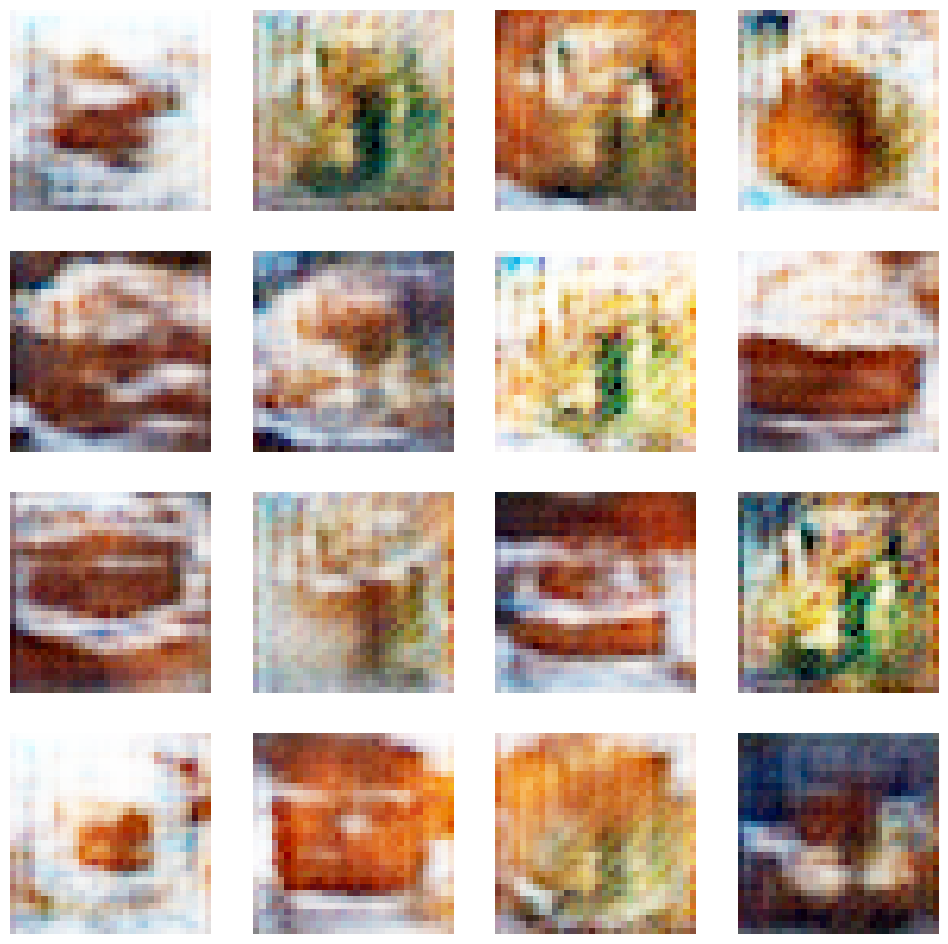

Epochs 2101-2160/3000: 100%|██████████| 3660/3660 [04:13<00:00, 14.41batch/s, D_loss=0.557, G_loss=2.06]


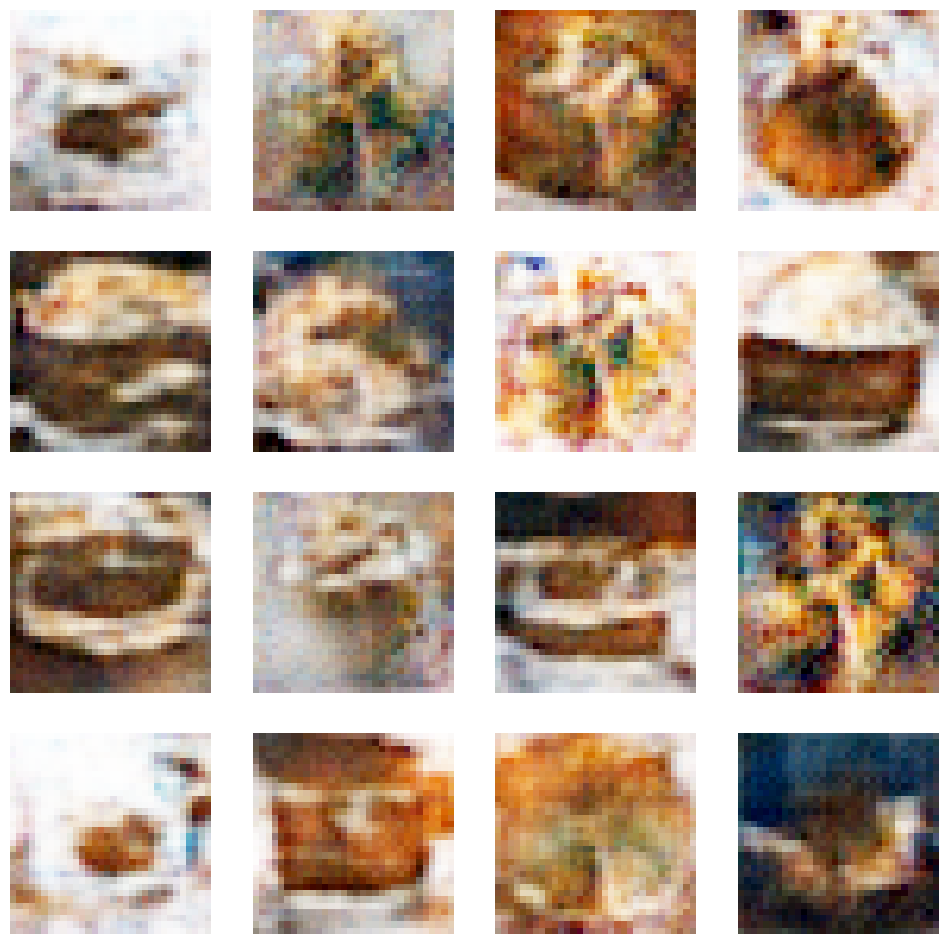

Epochs 2161-2220/3000: 100%|██████████| 3660/3660 [04:15<00:00, 14.32batch/s, D_loss=0.563, G_loss=1.7]  


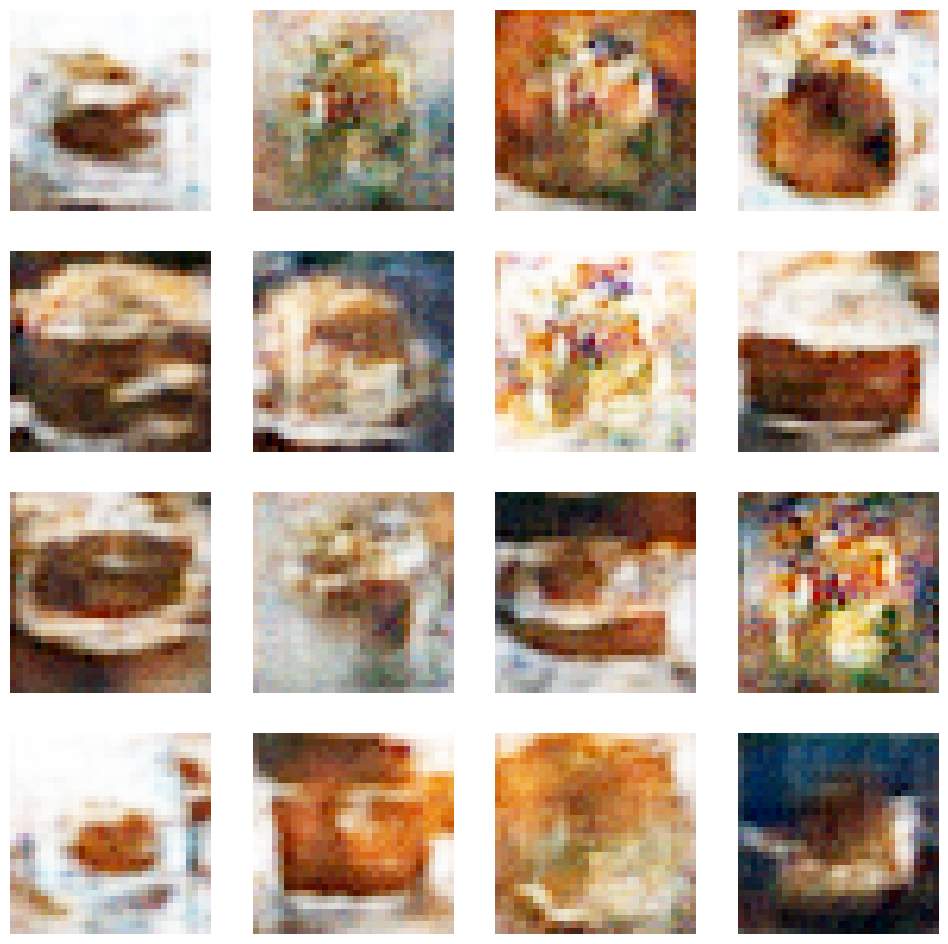

Epochs 2221-2280/3000: 100%|██████████| 3660/3660 [04:17<00:00, 14.19batch/s, D_loss=0.622, G_loss=2.77] 


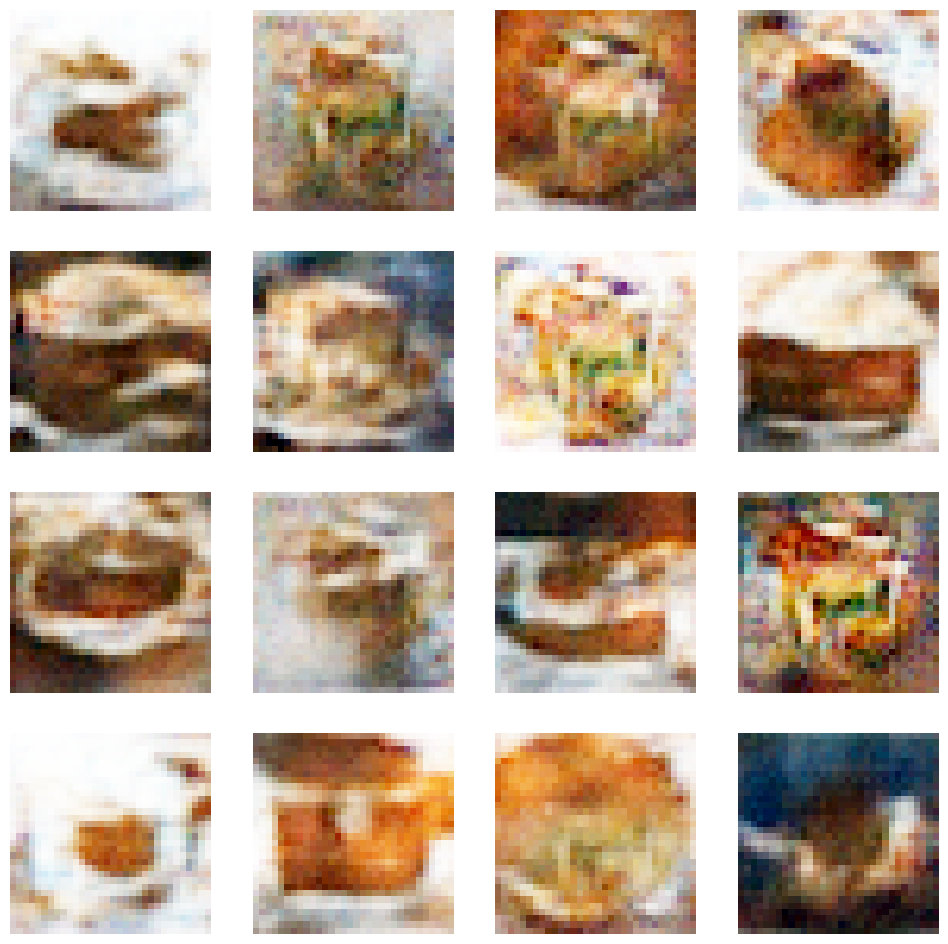

Epochs 2281-2340/3000: 100%|██████████| 3660/3660 [04:23<00:00, 13.92batch/s, D_loss=0.402, G_loss=2.89]


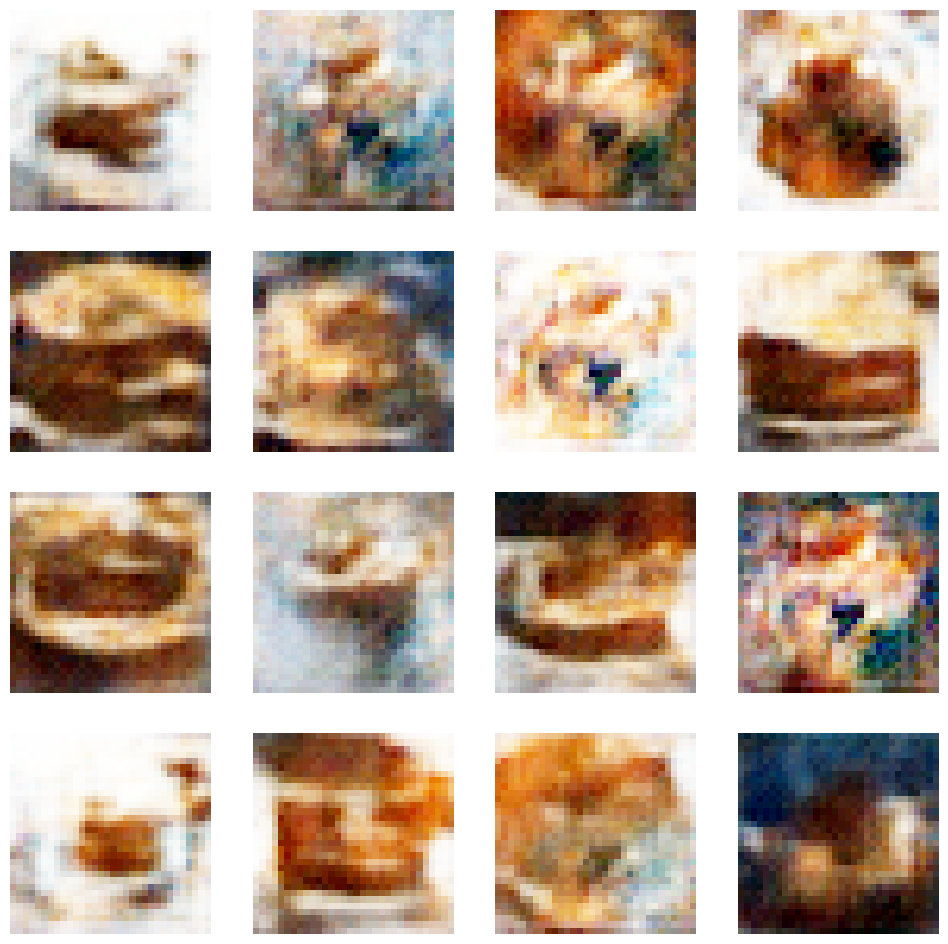

Epochs 2341-2400/3000: 100%|██████████| 3660/3660 [04:12<00:00, 14.48batch/s, D_loss=0.548, G_loss=2.28] 


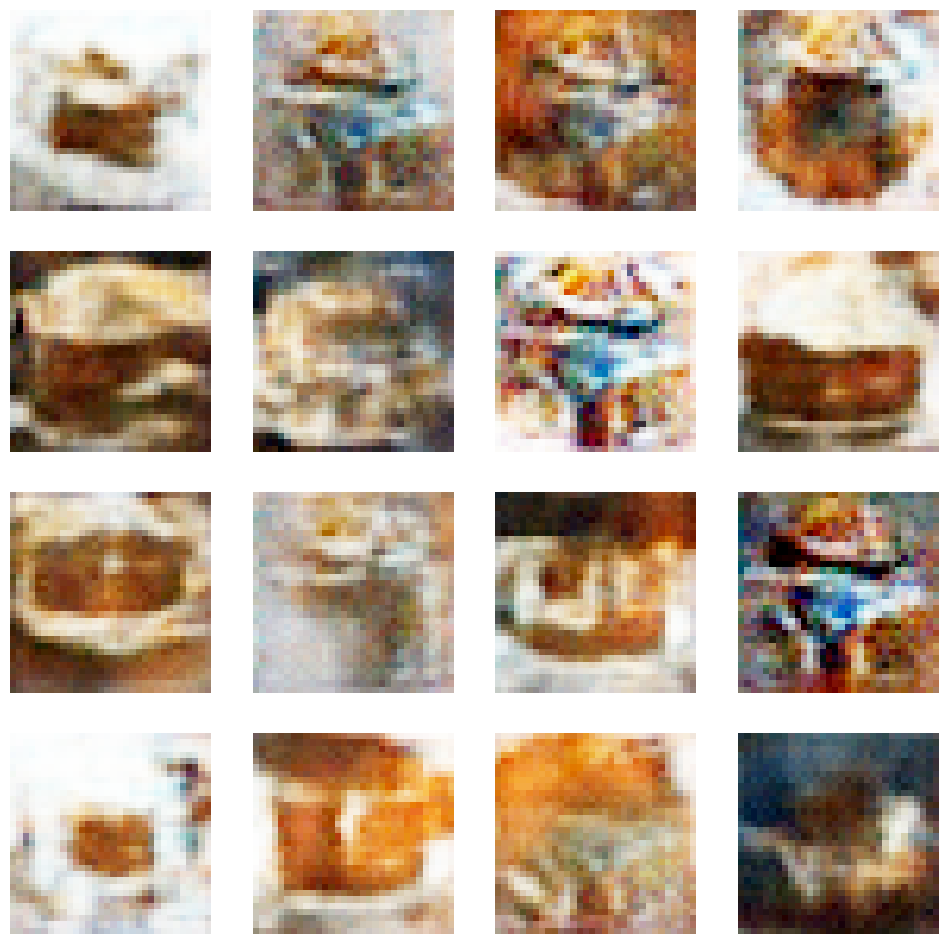

Epochs 2401-2460/3000: 100%|██████████| 3660/3660 [04:13<00:00, 14.41batch/s, D_loss=0.603, G_loss=2.33] 


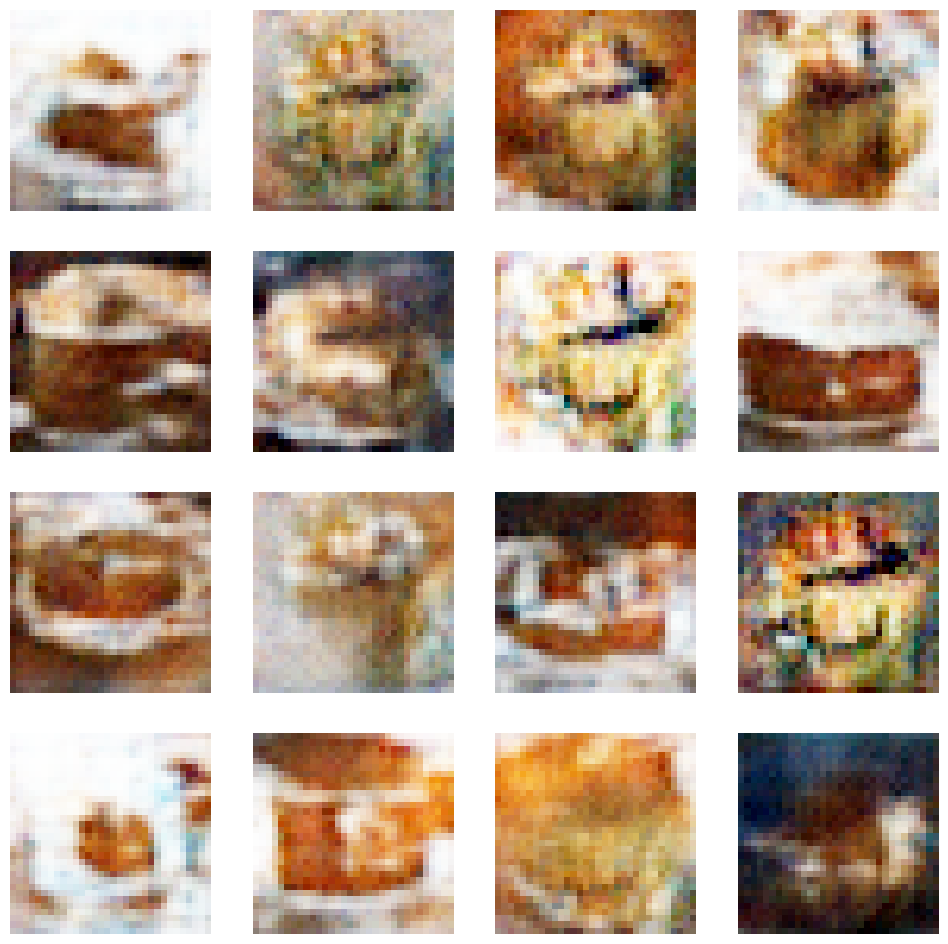

Epochs 2461-2520/3000: 100%|██████████| 3660/3660 [04:11<00:00, 14.57batch/s, D_loss=0.472, G_loss=2.66]


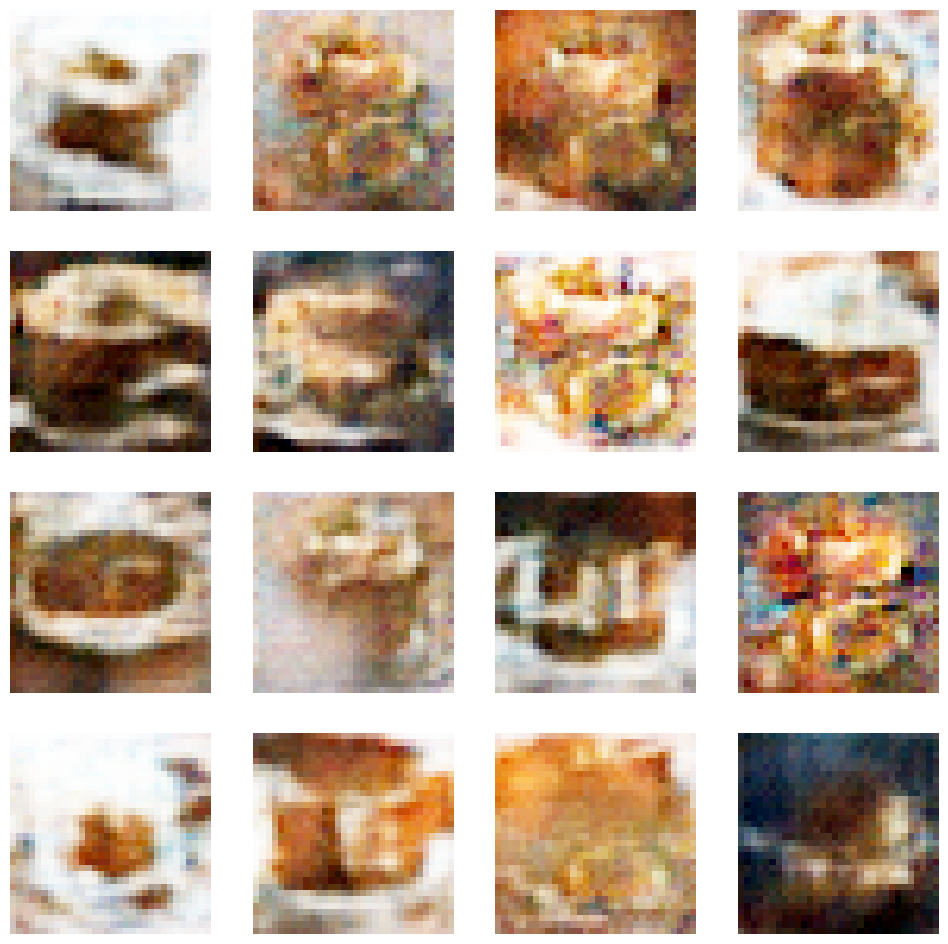

Epochs 2521-2580/3000: 100%|██████████| 3660/3660 [04:13<00:00, 14.43batch/s, D_loss=0.476, G_loss=2.61] 


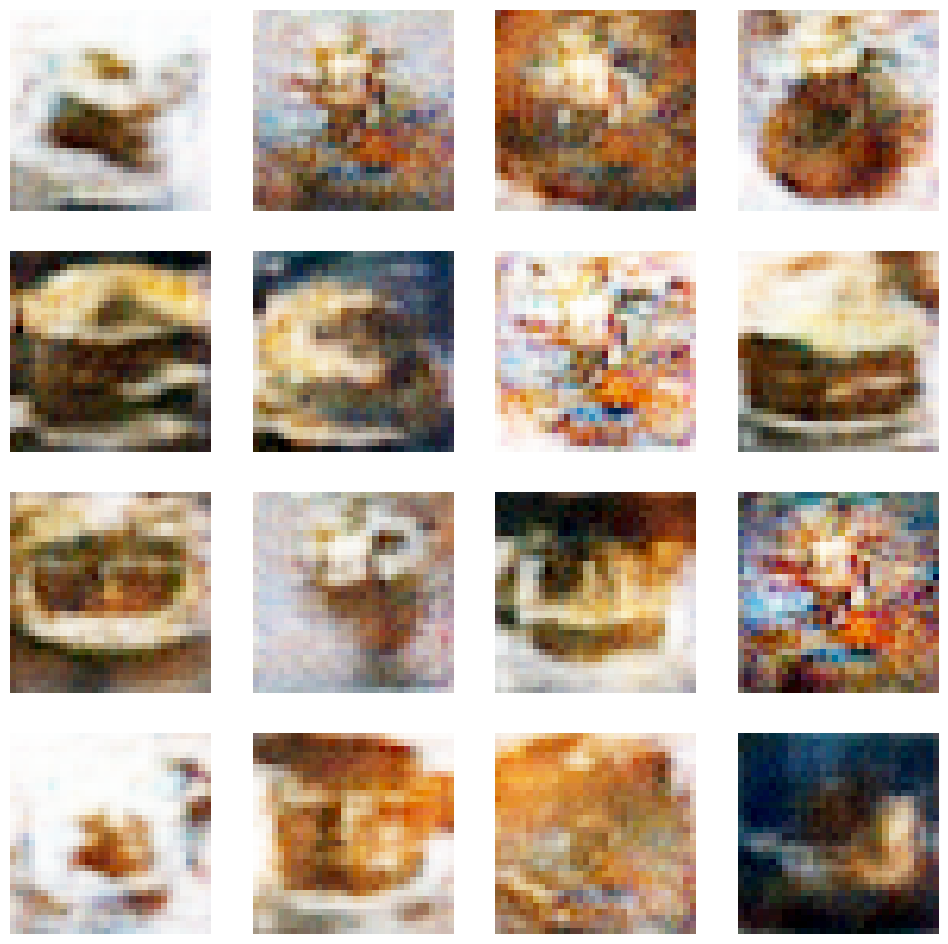

Epochs 2581-2640/3000: 100%|██████████| 3660/3660 [04:13<00:00, 14.46batch/s, D_loss=0.386, G_loss=2.82]


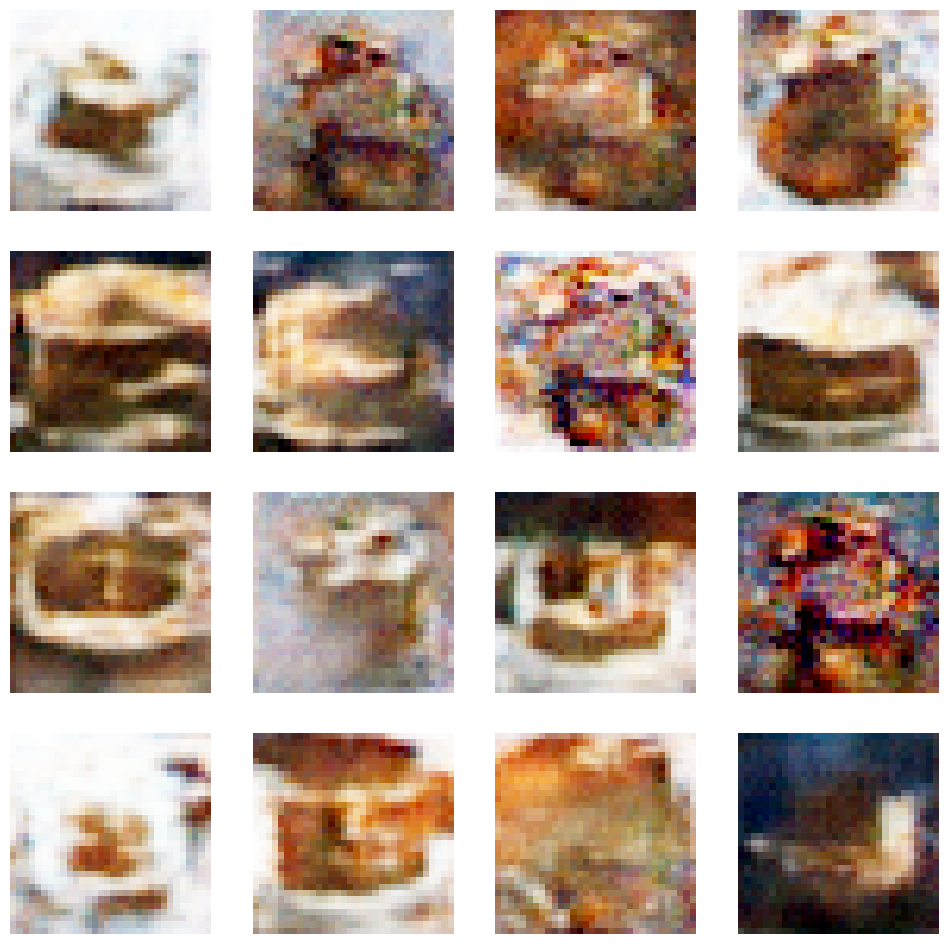

Epochs 2641-2700/3000: 100%|██████████| 3660/3660 [04:08<00:00, 14.76batch/s, D_loss=0.506, G_loss=2.12] 


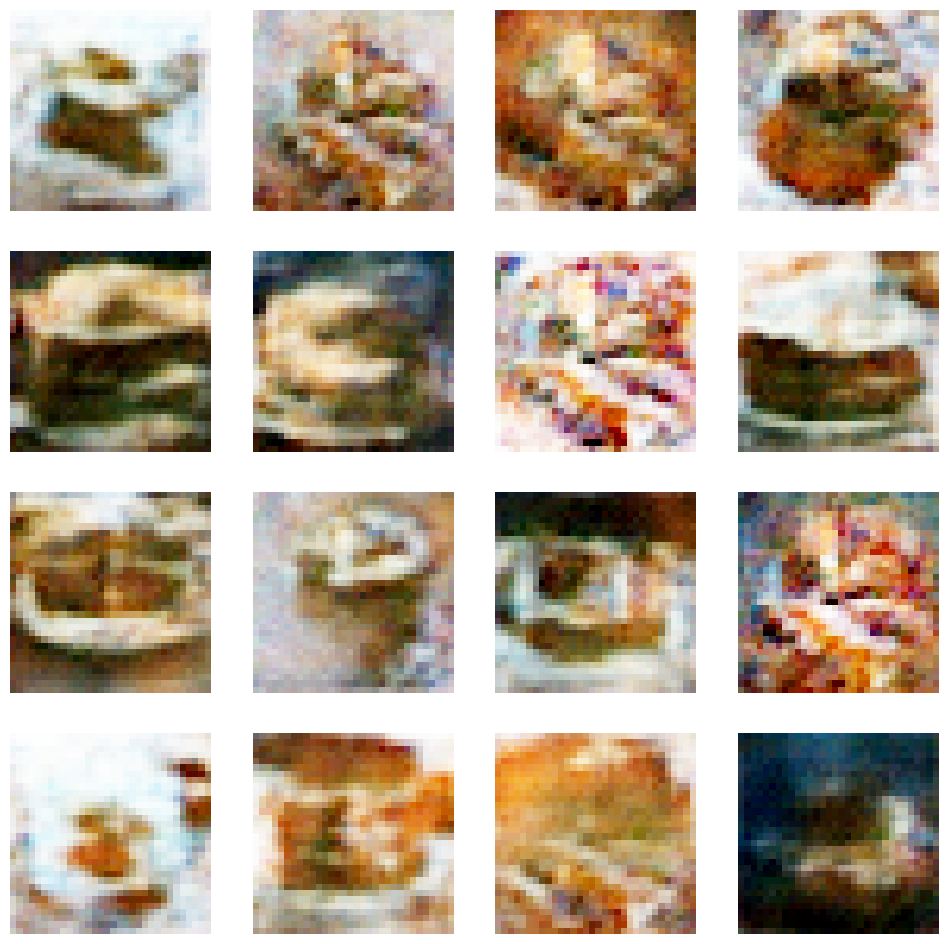

Epochs 2701-2760/3000: 100%|██████████| 3660/3660 [04:06<00:00, 14.83batch/s, D_loss=0.572, G_loss=2.46]


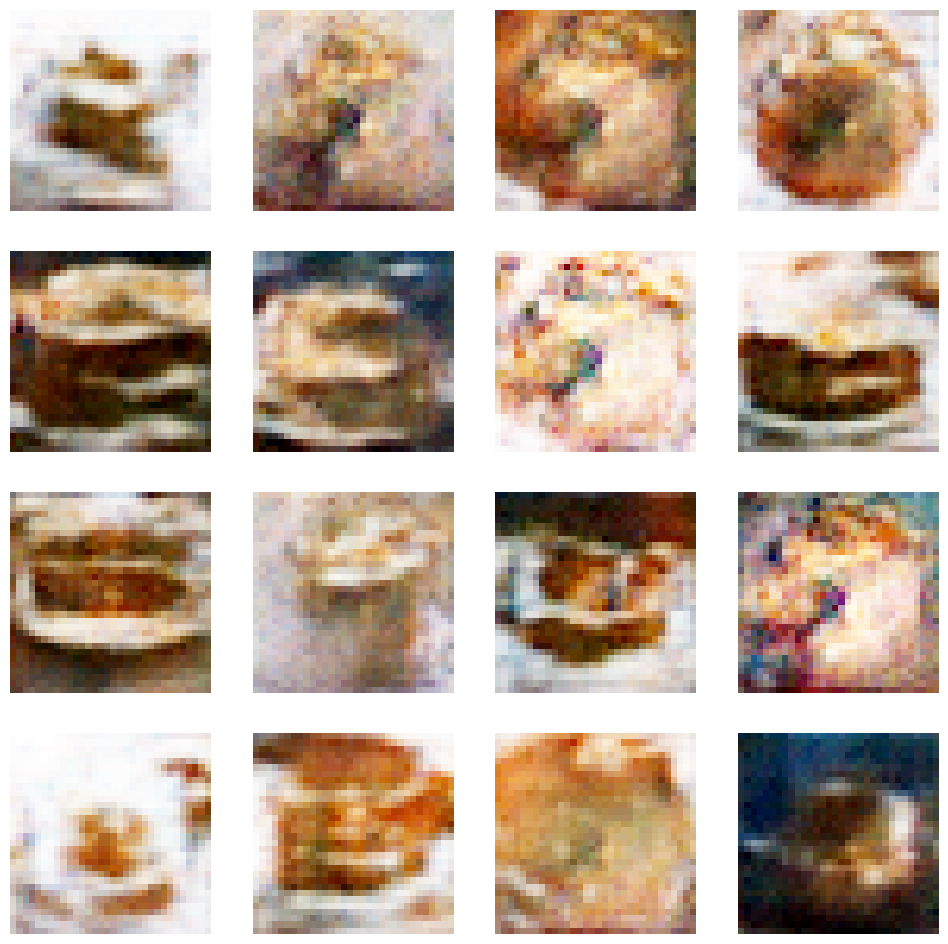

Epochs 2761-2820/3000: 100%|██████████| 3660/3660 [04:08<00:00, 14.72batch/s, D_loss=0.667, G_loss=1.86]


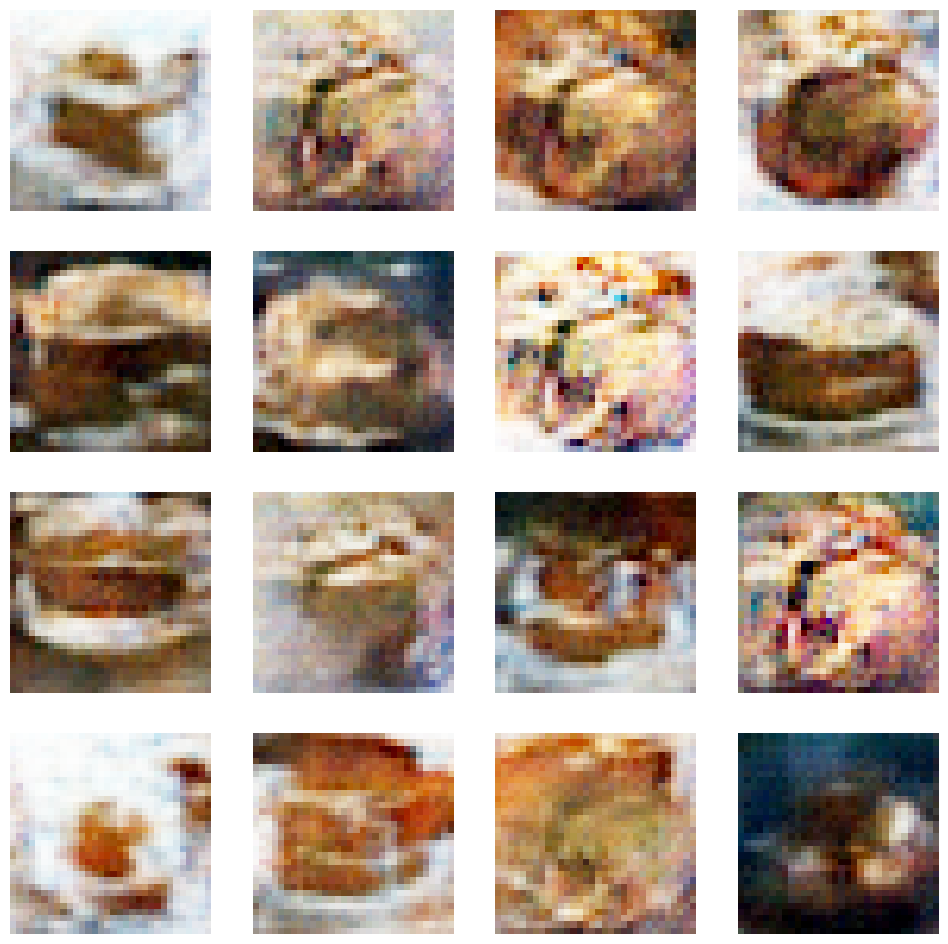

Epochs 2821-2880/3000: 100%|██████████| 3660/3660 [04:06<00:00, 14.84batch/s, D_loss=0.532, G_loss=2.9] 


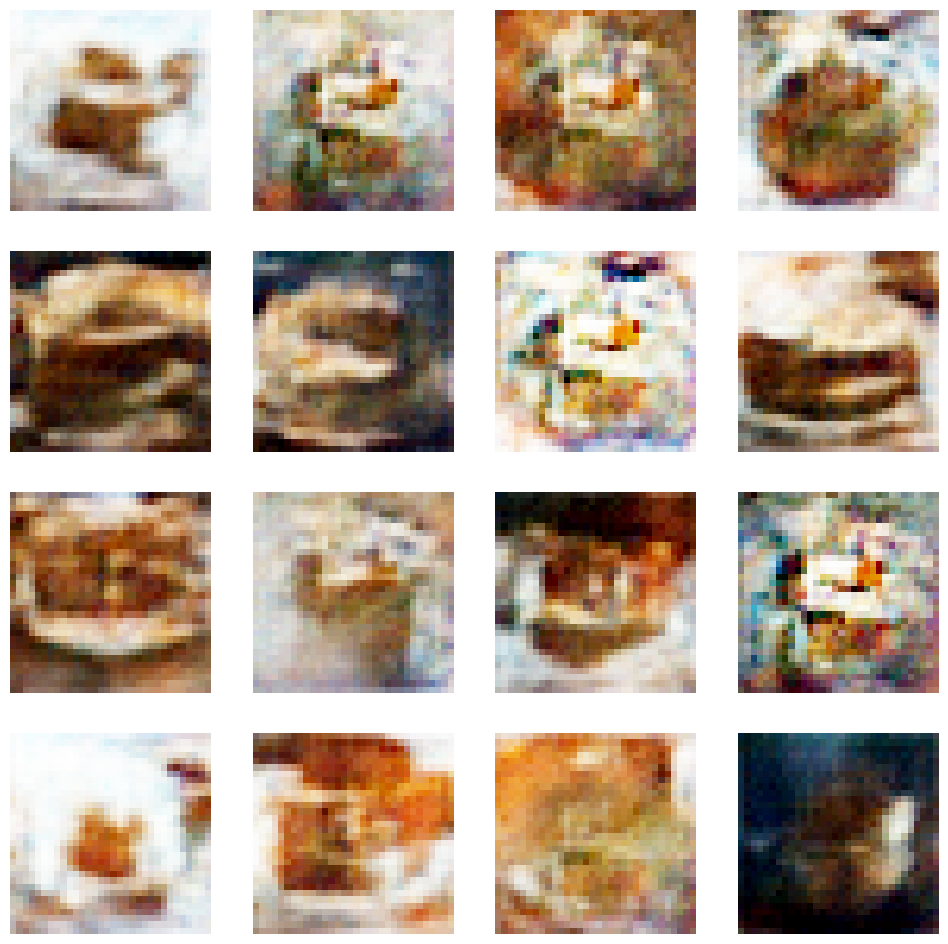

Epochs 2881-2940/3000: 100%|██████████| 3660/3660 [04:12<00:00, 14.50batch/s, D_loss=0.5, G_loss=2.56]  


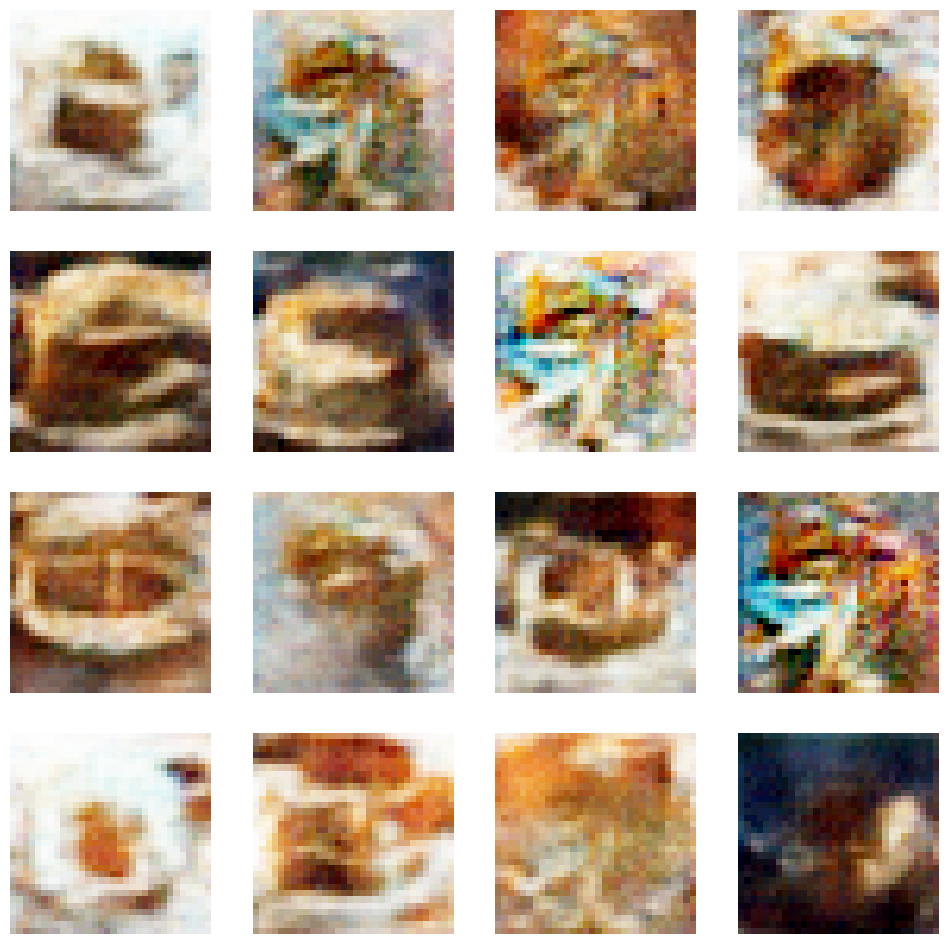

Epochs 2941-3000/3000: 100%|██████████| 3660/3660 [04:20<00:00, 14.03batch/s, D_loss=0.515, G_loss=2.09]


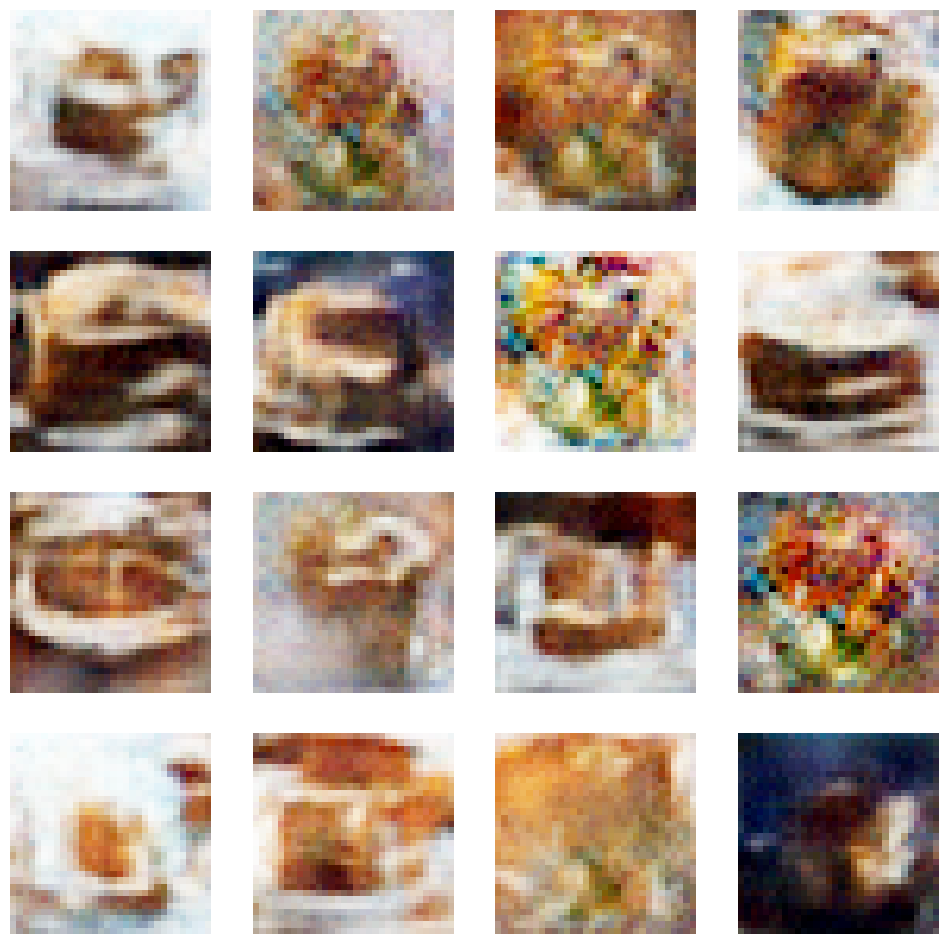

Epochs 3001-3060/3000:   0%|          | 0/3660 [00:00<?, ?batch/s]

In [16]:
print("START")
history_d = []
history_g = []

discriminator.train()
generator.train()

# input
gen_test = generator(fixed_noise)
y_pred_test = discriminator(gen_test)
show_tensor_images(gen_test.detach())

# progress bar
pbar = tqdm(total = verbose*len(data_loader), desc=f"Epochs {1}-{verbose}/{num_epochs}", unit="batch") 

for epoch in range(num_epochs):

    # training loop
    for i, (X_batch_real, y_batch_real) in enumerate(data_loader):
        """
            Train discriminator.
        """
        
        ## all real batch
        discriminator.zero_grad()
        
        y_batch_real -= torch.rand_like(y_batch_real) * 0.05 # modify the y_batch by randomizing the labels with noise
        y_pred_real  = discriminator(X_batch_real)

        err_d_real = criterion(y_pred_real, y_batch_real)
        err_d_real.backward()

        ## all fake batch
        noise_batch_fake = torch.randn(y_batch_real.shape[0], 64, device=device)
        y_batch_fake = torch.zeros_like(y_batch_real).to(device) + torch.rand_like(y_batch_real) * 0.05 # modify the labels by random noise    

        X_batch_fake = generator(noise_batch_fake)

        y_pred_fake = discriminator(X_batch_fake.detach())
        
        err_d_fake = criterion(y_pred_fake, y_batch_fake)
        err_d_fake.backward()

        # calculate error for discriminator
        err_d = err_d_real + err_d_fake
        # train discriminator
        optimizer_d.step()

        """
            Train generator.
        """
        generator.zero_grad()
        
        y_pred_gen = discriminator(X_batch_fake)
        y_batch_gen = torch.ones_like(y_batch_real).to(device)

        err_g = criterion(y_pred_gen, y_batch_gen)
        err_g.backward()

        optimizer_g.step()

        """
            Display proggress
        """
        # if i % 62 == 0:
        #     print(f"{epoch}: [{i}/{len(data_loader)}] -> Discriminator: {err_d.item()}, Generator: {err_g.item()}")

        history_d.append(err_d.item())
        history_g.append(err_g.item())

        # progress bar
        pbar.update(1)
        pbar.set_postfix({"D_loss": err_d.item(), "G_loss": err_g.item()})

    if (epoch+1) % verbose == 0:
        pbar.close()

        gen_test = generator(fixed_noise.detach())
        show_tensor_images(gen_test.detach().cpu(), save="generated", filename=f"checkpoint_epoch_{epoch}.png")
        # new progress bar
        pbar = tqdm(total = verbose*len(data_loader), desc=f"Epochs {epoch+2}-{epoch+1+verbose}/{num_epochs}", unit="batch") 

    if (epoch+1) % checkpoint == 0:
        save_models(discriminator, optimizer_d, generator, optimizer_g, epoch)

In [17]:
def plot_training_history(history_d, history_g):
    plt.figure(figsize=(10, 5))
    plt.plot(history_d, label="Discriminator Loss", color="blue")
    plt.plot(history_g, label="Generator Loss", color="red")
    plt.xlabel("Batch Number")
    plt.ylabel("Loss")
    plt.title("Training Loss History")
    plt.legend()
    plt.show()

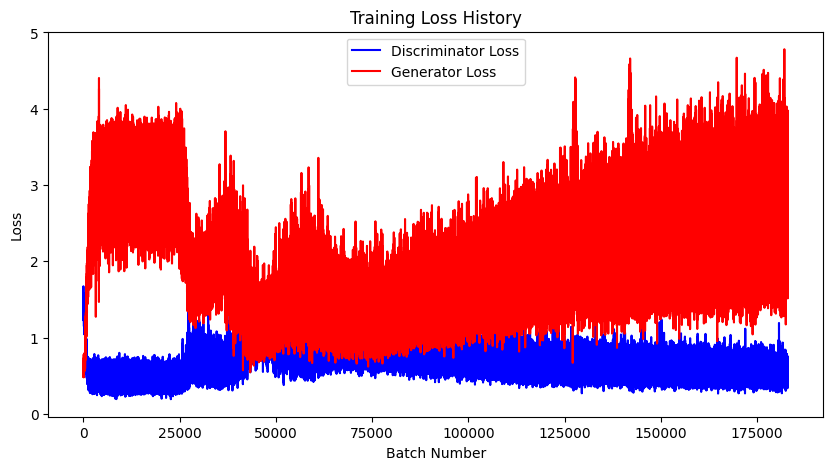

In [18]:
# show training history
plot_training_history(history_d, history_g)

In [93]:
def load_models(model_d, optim_d, model_g, optim_g, path):
    checkpoint = torch.load(path)
    epoch = checkpoint['epoch']
    
    model_d.load_state_dict(checkpoint['model_d_state_dict'])
    model_g.load_state_dict(checkpoint['model_g_state_dict'])
    
    optim_d.load_state_dict(checkpoint['optimizer_d_state_dict'])
    optim_g.load_state_dict(checkpoint['optimizer_g_state_dict'])
    
    return epoch

In [94]:
model_d = Discriminator()
optim_d = optim.Adam(model_d.parameters(), lr=1e-4)
model_g = Generator()
optim_g = optim.Adam(model_g.parameters(), lr=1e-4)
path = "models/checkpoint_epoch_2999.pth"

In [95]:
load_models(model_d, optim_d, model_g, optim_g, path)

2999

torch.Size([3, 32, 32])


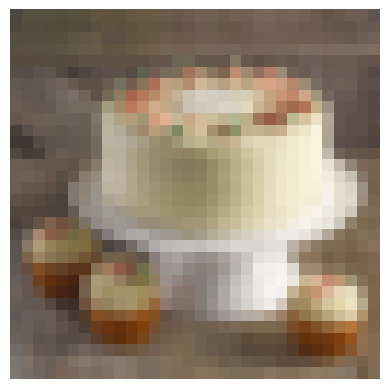

In [137]:
X_batch, _ = next(iter(data_loader))
target_image = X_batch[0].to('cpu')
print(target_image.shape)
show_tensor_image(target_image)

In [138]:
import torch.nn.functional as F

In [141]:
evolution_images = []
input_vector = torch.randn(1, 64, requires_grad=True)

optimizer = optim.SGD([input_vector], lr=0.1, momentum=0.9)
epochs = 630

model_g.eval()

for epoch in range(epochs):
    optimizer.zero_grad()
    
    generated_image = model_g(input_vector)[0]
    
    loss = F.mse_loss(generated_image, target_image)
    
    loss.backward()
    optimizer.step()
    
    if epoch % (epochs//9) == 0:
       evolution_images.append(generated_image.detach().cpu())
       print(loss.item())


0.23379729688167572
0.14903171360492706
0.08761204034090042
0.07367327064275742
0.06190359592437744
0.052418302744627
0.04629765823483467
0.04199172556400299
0.03873242437839508


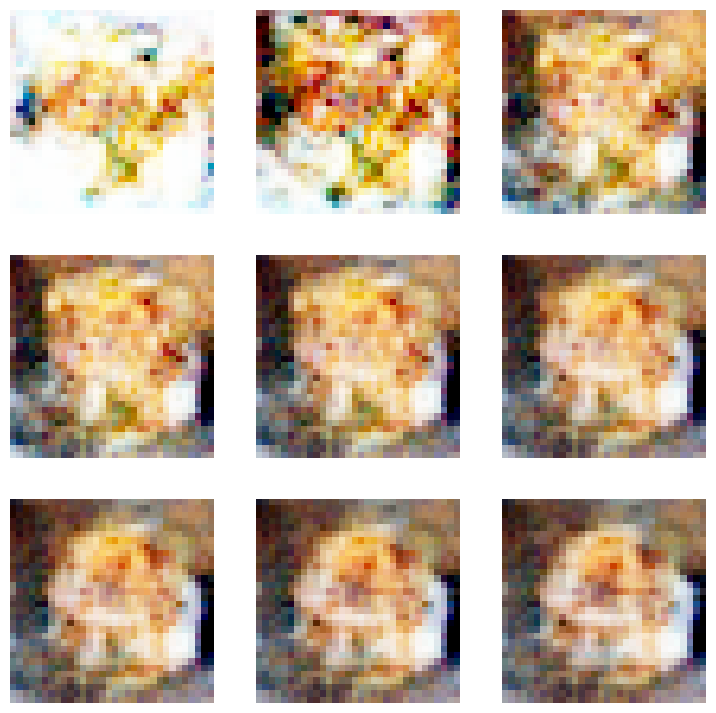

In [142]:
show_tensor_images(evolution_images, to_cpu=False)

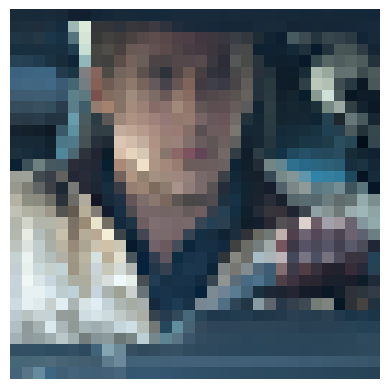

In [150]:
target_image = Image.open("other_image.png").convert("RGB")
target_image = transform(target_image)

show_tensor_image(target_image)

In [151]:
evolution_images = []
input_vector = torch.randn(1, 64, requires_grad=True)

optimizer = optim.SGD([input_vector], lr=0.1, momentum=0.9)
epochs = 630

model_g.eval()

for epoch in range(epochs):
    optimizer.zero_grad()
    
    generated_image = model_g(input_vector)[0]
    
    loss = F.mse_loss(generated_image, target_image)
    
    loss.backward()
    optimizer.step()
    
    if epoch % (epochs//9) == 0:
       evolution_images.append(generated_image.detach().cpu())
       print(loss.item())


0.37657639384269714
0.1957348734140396
0.15229357779026031
0.12255821377038956
0.10763902217149734
0.09863714128732681
0.09282038360834122
0.08770939707756042
0.08397096395492554


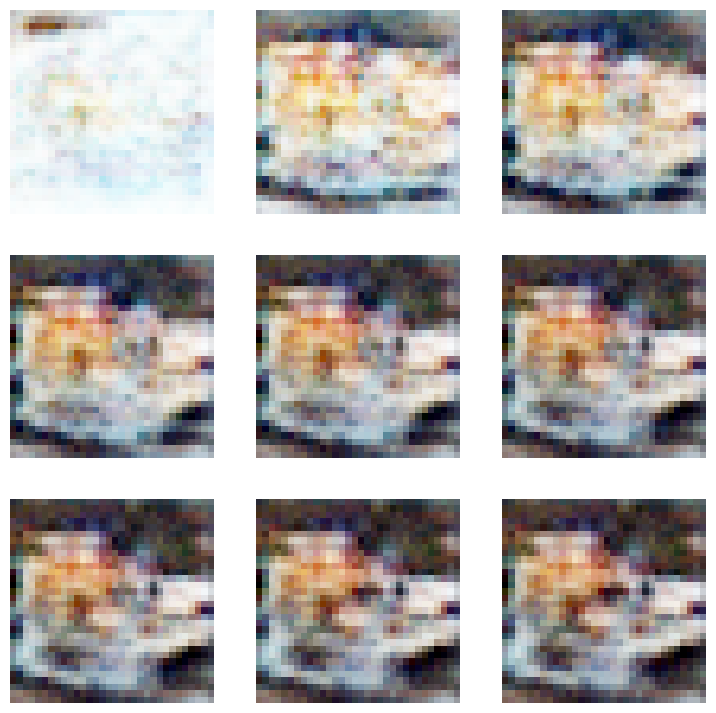

In [152]:
show_tensor_images(evolution_images, to_cpu=False)